In [1]:
#Imports and such
import csv
import glob
from PIL import Image
import PIL.ImageOps as ImageOps
import numpy as np
import matplotlib.pyplot as plt
from sklearn import mixture
import torch
import random
from torch import nn
from collections import deque
from scipy.spatial import distance

%matplotlib inline

## Data processing and training GMM

In [2]:
def image_to_graph(image_path, crop_left, crop_bottom, bar_offset):
    
    img = Image.open(image_path).convert('L')
    pix = np.array(img.getdata()).reshape(img.size[1], img.size[0])
    #print("Greyscale image")
    #display(Image.fromarray(pix.astype('uint8'), 'L'))
    
    #Crop image to get rid of stuff we don't need
    cropped_pix = np.delete(pix, np.s_[0:crop_left], axis=1)
    cropped_pix = np.delete(cropped_pix, np.s_[cropped_pix.shape[0] - crop_bottom:cropped_pix.shape[0]], axis=0)

    #Display to check crop
    #print("Cropped image")
    #display(Image.fromarray(cropped_pix.astype('uint8')+255, 'L'))

    #Invert the image
    cropped_pix = 255-cropped_pix
    
    #Extract vertical "bars" from image pixel array
    bars = []
    average_bars = []
    for i in range(24):
        bars.append(cropped_pix[:,int((i*cropped_pix.shape[1])/24)+bar_offset])

    #Calculate average pixel value from each bar, as this will correspond to the average height of that bar
    for bar in bars:
        average_bars.append(np.mean(bar))
    
    #Normalise to 1.0
    average_bars = average_bars/np.max(average_bars)
    average_bars = np.clip(average_bars, 0, 0.8)
    
    #Plot to check data
    #print("Extracted data")
    #plt.figure(figsize=(12, 2))
    #plt.bar(range(0,24), average_bars)
    #plt.show()
    #print("\n\n")
    
    # Clip values to the range [0, 0.8]
    return average_bars


def write_to_csv(files, filename):

    # open the file in the write mode
    f = open(filename, 'w')

    # create the csv writer
    writer = csv.writer(f)

    for i in range(len(files)):
        print("Graph nr", str(i+1))
        writer.writerow(image_to_graph(files[i], 2, 20, 10))

    f.close()

# All files and directories ending with .txt and that don't begin with a dot:
files = glob.glob("./graph-digitization/charts/*.png")



In [3]:
data = []
for file in files:
    data.append(image_to_graph(file, 2, 20, 10))
data = np.asarray(data)
data.shape

(124, 24)

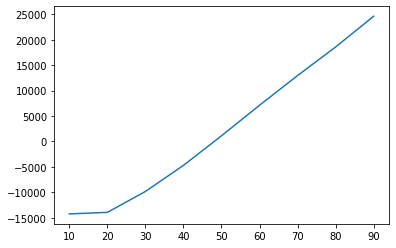

In [4]:
n_components = np.arange(10, 100, 10)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
# plt.xlabel("Number of components")
# plt.ylabel("AIC")
plt.plot(n_components, aics)
plt.show()

True


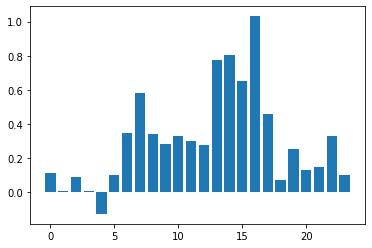

In [5]:
gmm = mixture.GaussianMixture(10, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)
plt.bar(range(0,24), gmm.sample(10)[0][4])
plt.show()

### Compare data distribution with GMM samples


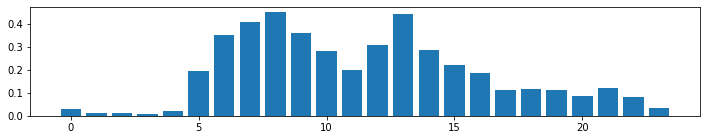

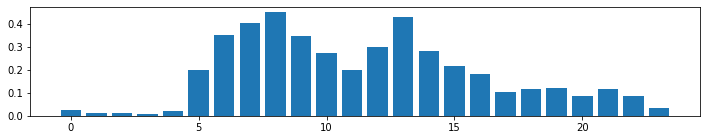

In [6]:
dist_real = np.mean(data, axis=0)
dist_synth = np.mean(gmm.sample(1000)[0], axis=0)


plt.figure(figsize=(12, 2))
# plt.xlabel("Hour")
# plt.ylabel("Response probability")
plt.bar(range(0,24), dist_real)
plt.show()
plt.figure(figsize=(12, 2))
# plt.xlabel("Hour")
# plt.ylabel("Response probability")
plt.bar(range(0,24), dist_synth)
plt.show()

In [257]:
print("Jensen-Shannon Divergence:", distance.jensenshannon((dist_real/np.sum(dist_real)), (dist_synth/np.sum(dist_synth))))
print("Means", np.mean(dist_real), np.mean(dist_synth))
#standard deviation

Jensen-Shannon Divergence: 0.009964530009371192
Means 0.1852891379098105 0.18247133831687265


## RL Environment

In [145]:
class CustomerBaseEnvironment:
    def __init__(self, customer_response_functions, reward_response, reward_ignore):
        self.customer_response_functions = np.stack(
            customer_response_functions, axis=0)
        self.n_actions = 24
        self.n_states = len(customer_response_functions)
        self.reward_response = reward_response
        self.reward_ignore = reward_ignore

    def step(self, state, action):
        done = False

        p = random.uniform(0, 1)

        response_probability = self.customer_response_functions[state][action]

        reward = self.reward_ignore

        if p < response_probability:
            reward = self.reward_response

        if state == self.n_states - 1:
            done = True
        else:
            state += 1

        return state, reward, done
    
    def get_optimal_policy(self):
        l = []
        for c in self.customer_response_functions:
            l.append(np.argmax(c))
        return np.array(l)



class CustomerBaseEnvironmentWithOpt(CustomerBaseEnvironment):
    def __init__(self,
                 customer_response_functions,
                 reward_response,
                 reward_ignore,
                 opt_out_prob=0.0003,
                 opt_in_prob=0.001):
        self.customer_response_functions = np.stack(
            customer_response_functions, axis=0)
        self.n_actions = 25
        self.n_states = len(customer_response_functions)
        self.reward_response = reward_response
        self.reward_ignore = reward_ignore
        self.opt_out = np.zeros(self.n_states)
        self.opt_out_prob = opt_out_prob
        self.opt_in_prob = opt_in_prob

    def step(self, state, action):
        done = False

        p = random.uniform(0, 1)

        reward = 0

        # We check that communication is being sent to this customer
        if action != 24:
            response_probability = self.customer_response_functions[state][
                action]
            reward = self.reward_ignore
            # We also check that the customer is opted in
            if p < response_probability and self.opt_out[state] == 0:
                reward = self.reward_response
        #Random opt out
        if random.uniform(0, 1) < self.opt_out_prob:
            self.opt_out[state] = 1
        #Allow random opt in
        if random.uniform(0,
                          1) < self.opt_in_prob and self.opt_out[state] == 1:
            #print("Opted back in!")
            self.opt_out[state] = 0
        if state == self.n_states - 1:
            done = True
        else:
            state += 1
        # Also return the opt-in status of this customer
        return state, reward, done, self.opt_out[state - 1]

class CustomerBaseEnvironmentWithInactive(CustomerBaseEnvironmentWithOpt):
    def __init__(self,
                 customer_response_functions,
                 reward_response,
                 reward_ignore,
                 opt_out_prob=0.0003,
                 opt_in_prob=0.001, prob_inactive=0.0001, prop_active=0.0001):
        self.customer_response_functions = np.stack(
            customer_response_functions, axis=0)
        self.n_actions = 25
        self.n_states = len(customer_response_functions)
        self.reward_response = reward_response
        self.reward_ignore = reward_ignore
        self.opt_out = np.zeros(self.n_states, dtype=int)
        self.opt_out_prob = opt_out_prob
        self.opt_in_prob = opt_in_prob
        self.prob_inactive = prob_inactive
        self.prop_active = prop_active
        self.inactive = np.zeros(self.n_states, dtype=int)

    def step(self, state, action):
        done = False

        p = random.uniform(0, 1)

        reward = 0

        # We check that communication is being sent to this customer
        if action != 24:
            response_probability = self.customer_response_functions[state][
                action]
            reward = self.reward_ignore
            # We also check that the customer is active
            if p < response_probability and self.inactive[state] == 0:
                reward = self.reward_response
            
        # Only active customers can opt in/out
        if self.inactive[state] == 0:
            #Random opt out
            if random.uniform(0, 1) < self.opt_out_prob:
                self.opt_out[state] = 1
            #Allow random opt in
            if random.uniform(0, 1) < self.opt_in_prob and self.opt_out[state] == 1:
                self.opt_out[state] = 0
                self.inactive[state] = 0
        
        # Only opted in customers can become active/inactive
        if self.opt_out[state] == 0:
            if random.uniform(0,1) < self.prob_inactive:
                self.inactive[state] = 1
            if random.uniform(0,1) < self.prop_active:
                self.inactive[state] = 0
                
        if state == self.n_states - 1:
            done = True
        else:
            state += 1
        # Also return the opt-in status of this customer
        return state, reward, done, self.opt_out[state - 1]

class CustomerBaseFinalForm(CustomerBaseEnvironmentWithInactive):
    def __init__(self,
                 customer_response_functions,
                 reward_response,
                 reward_ignore,
                 opt_out_prob=0.003,
                 opt_in_prob=0.0003, prob_inactive=0.0001, prop_active=0.0001, ctp=0.0001, unsub_freq=14):
        self.customer_response_functions = np.stack(
            customer_response_functions, axis=0)
        self.n_actions = 25
        self.n_states = len(customer_response_functions)
        self.reward_response = reward_response
        self.reward_ignore = reward_ignore
        self.opt_out = np.zeros(self.n_states, dtype=int)
        self.opt_out_prob = opt_out_prob
        self.opt_in_prob = opt_in_prob
        self.prob_inactive = prob_inactive
        self.prop_active = prop_active
        self.inactive = np.zeros(self.n_states, dtype=int)
        self.ctp = ctp
        self.num_transitions = 0
        self.unsub_freq = unsub_freq
        self.mean_probabilities = np.mean(customer_response_functions, axis=0)
    
    def reset(self):
        return 0
    
    def addCustomers(self, n):
        new_customers = [cust for cust in gmm.sample(n)[0]]
        self.customer_response_functions = np.concatenate((self.customer_response_functions, np.stack(new_customers, axis=0)), axis=0)
        self.n_states = len(self.customer_response_functions)
        self.opt_out = np.concatenate((self.opt_out, np.zeros(n, dtype=int)), axis=0)
        self.inactive = np.concatenate((self.inactive, np.zeros(n, dtype=int)), axis=0)

    def step(self, state, action, current_day):
        done = False

        p = random.uniform(0, 1)

        reward = 0

        # We check that communication is being sent to this customer
        if action != 24:
            response_probability = self.customer_response_functions[state][
                action]
            reward = self.reward_ignore
            # We also check that the customer is active
            if p < response_probability and self.inactive[state] == 0:
                reward = self.reward_response
            
        # Only active customers can opt in/out
        if self.inactive[state] == 0 and current_day % self.unsub_freq == 0:
            #Random opt out
            if random.uniform(0, 1) < self.opt_out_prob:
                self.opt_out[state] = 1
            #Allow random opt in
            if random.uniform(0, 1) < self.opt_in_prob and self.opt_out[state] == 1:
                self.opt_out[state] = 0
                self.inactive[state] = 0
        
        # Only opted in customers can become active/inactive
        if self.opt_out[state] == 0:
            if random.uniform(0,1) < self.prob_inactive:
                self.inactive[state] = 1
            if random.uniform(0,1) < self.prop_active:
                self.inactive[state] = 0
        
        self.change_context(state)
                
        if state == self.n_states - 1:
            done = True
        else:
            state += 1
        # Also return the opt-in status of this customer

        return state, reward, done, self.opt_out[state - 1]

    # def clip_rp_function(self, y, max_probability=0.8, min=0.0):
    #     # Clip function
    #     return np.clip(y, 0, 0.8)
    
    def alter_function(self, y, severity):
        mean = np.mean(y) 
        for i in range(len(y)):
            p = self.mean_probabilities[i]
            if random.uniform(0, 1) < p:
                mod = random.uniform(0, severity)
                if random.uniform(0, 1) > 0.5:
                    y[i] = y[i] + mod
                else:
                    y[i] = y[i] - mod
        y_clipped = np.clip(y, 0, 0.8)
        mean_diff = mean - np.mean(y_clipped)
        return y_clipped + mean_diff

    def change_context(self, state):
        if random.uniform(0, 1) < self.ctp:
            self.customer_response_functions[state] = self.alter_function(self.customer_response_functions[state], severity=0.05, probability=0.5)
            self.num_transitions = self.num_transitions + 1

## RL Agents (TABULAR)


In [146]:
class QLearningAgentForFullCustomerBase:
    def __init__(self,
                 env,
                 eps_start=1.0,
                 eps_decay=0.096,
                 eps_min=0.001,
                 gamma=0.99,
                 alpha=0.99):
        self.env = env
        self.eps_start = eps_start
        self.epsilon = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.gamma = gamma
        self.alpha = alpha
        self.Q = np.zeros((env.n_actions, env.n_states), dtype=float)
        self.Q_history = []
        self.reward_buffer = []
        self.mse_buffer = []
        self.iteration_cntr = 1

    def choose_action(self, state):
        '''
        Returns an e-greedy action
        '''
        epsilon = max(self.epsilon, self.eps_min)

        if random.uniform(0, 1) < epsilon:
            # Explore
            action = np.random.choice(range(self.env.n_actions))
            return action
        else:
            # Exploit
            actions = self.Q[:, state]

            return np.argmax(actions)

    def update_Q(self, memory):
        (state, action, state_, reward) = memory
        error = self.gamma * np.max(self.Q[:, state_]) - self.Q[action, state]
        '''
        Based on the Q-learning update function on https://www.cse.unsw.edu.au/~cs9417ml/RL1/algorithms.html
        '''
        self.Q[action, state] = self.Q[action, state] + \
            self.alpha * (reward + error)

    def save_Q_snapshot(self):
        self.Q_history.append(self.Q)

    def decay_eps(self):
        if self.epsilon > self.eps_min:
            self.epsilon = self.eps_decay * self.epsilon

    def reset_epsilon(self):
        self.epsilon = self.eps_start

    def reset_Q(self):
        self.Q = np.zeros((self.env.n_actions, self.env.n_states), dtype=float)

    def print_policy(self):
        policy = []
        for i in range(self.env.n_states):
            policy.append(np.argmax(self.Q[:, i]))
        policy = np.array(policy)
        
        print(policy)

    def build_policy(self):
        policy = []
        for i in range(self.env.n_states):
            policy.append(np.argmax(self.Q[:, i]))
        return policy

class QLearningAgentForFullCustomerBaseWithOpting(QLearningAgentForFullCustomerBase):
    def __init__(self,
                 env,
                 eps_start=1.0,
                 eps_decay=0.096,
                 eps_min=0.001,
                 gamma=0.99,
                 alpha=0.99):
        self.env = env
        self.eps_start = eps_start
        self.epsilon = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.gamma = gamma
        self.alpha = alpha
        self.Q = np.zeros((env.n_actions, env.n_states), dtype=float)
        self.Q_history = []
        self.reward_buffer = []
        self.mse_buffer = []
        self.iteration_cntr = 1
        self.opt_out = np.zeros(env.n_states)
    
    def choose_action(self, state):
        '''
        Returns an e-greedy action
        '''
        # Do nothing if a customer is opted out
        
        if(self.opt_out[state] == 1):
            return self.env.n_actions - 1
        
        # Otherwise continue normally
        
        epsilon = max(self.epsilon, self.eps_min)

        if random.uniform(0, 1) < epsilon:
            # Explore
            action = np.random.choice(range(self.env.n_actions))
            return action
        else:
            # Exploit
            actions = self.Q[:, state]

            return np.argmax(actions)

    def update_Q(self, memory):
        (state, action, state_, reward, customer_opted_out) = memory
        self.opt_out[state] = customer_opted_out
        #if customer_opted_out == 1:
        #    return
        error = self.gamma * np.max(self.Q[:, state_]) - self.Q[action, state]
        '''
        Based on the Q-learning update function on https://www.cse.unsw.edu.au/~cs9417ml/RL1/algorithms.html
        '''
        self.Q[action, state] = self.Q[action, state] + \
            self.alpha * (reward + error)

In [353]:
class QLA_EPSILON_TRACKING(QLearningAgentForFullCustomerBaseWithOpting):
    def __init__(self,
                 env,
                 eps_start=1.0,
                 eps_decay=0.096,
                 eps_min=0.001,
                 gamma=0.99,
                 alpha=0.99, eps_max=0.3):
        self.env = env
        self.eps_start = eps_start
        self.epsilon = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.gamma = gamma
        self.alpha = alpha
        self.eps_max = eps_max
        #self.Q = np.random.rand(env.n_actions, env.n_states)
        self.Q = np.zeros((env.n_actions, env.n_states), dtype=float)
        self.Q_history = []
        self.reward_buffer = []
        self.mse_buffer = []
        self.iteration_cntr = 1
        self.opt_out = np.zeros(env.n_states)
        self.epsilon_array = self.eps_start * np.ones(env.n_states)

    def choose_action(self, state):
        '''
        Returns an e-greedy action
        '''
        # Do nothing if a customer is opted out

        if (self.opt_out[state] == 1):
            return env.n_actions - 1

        # Otherwise continue normally

        epsilon = max(self.epsilon_array[state], self.eps_min)

        if random.uniform(0, 1) < epsilon:
            # Explore
            action = np.random.choice(range(self.env.n_actions))
            return action
        else:
            # Exploit
            actions = self.Q[:, state]

            return np.argmax(actions)

    def decay_eps(self, state):
        if self.epsilon_array[state] > self.eps_min:
            self.epsilon_array[
                state] = self.eps_decay * self.epsilon_array[state]

    def update_Q(self, memory):
        
        (state, action, state_, reward, customer_opted_out) = memory
        
        if reward < 0 and self.epsilon_array[state] < self.eps_max:
            if customer_opted_out == 0:
                customer_eps = self.epsilon_array[state]
                self.epsilon_array[state] = np.minimum(customer_eps + 0.3, self.eps_max) #arbitrary bump, should test, also should not go above 1.0
        
        if self.opt_out[state] != customer_opted_out:
            #Bump up epsilon for customer when the customer opts back in
            self.opt_out[state] = customer_opted_out
        
        if customer_opted_out == 1:
            return
        
        error = self.gamma * np.max(self.Q[:, state_]) - self.Q[action, state]
        '''
        Based on the Q-learning update function on https://www.cse.unsw.edu.au/~cs9417ml/RL1/algorithms.html
        '''
        self.Q[action, state] = self.Q[action, state] + \
            self.alpha * (reward + error)

In [413]:
class RUQLA(QLearningAgentForFullCustomerBaseWithOpting):
    def __init__(self,
                 env,
                 eps_start=1.0,
                 eps_decay=0.096,
                 eps_min=0.001,
                 gamma=0.99,
                 alpha=0.99):
        self.env = env
        self.eps_start = eps_start
        self.epsilon = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.gamma = gamma
        self.alpha = alpha
        #self.Q = np.random.rand(env.n_actions, env.n_states)
        self.Q = np.zeros((env.n_actions, env.n_states), dtype=float)
        self.Q_history = []
        self.reward_buffer = []
        self.mse_buffer = []
        self.iteration_cntr = 1
        self.opt_out = np.zeros(env.n_states)
        self.epsilon = self.eps_start

    def choose_action(self, state):
        '''
        Returns an e-greedy action
        '''
        # Do nothing if a customer is opted out

        if (self.opt_out[state] == 1):
            return env.n_actions - 1

        # Otherwise continue normally

        epsilon = max(self.epsilon, self.eps_min)

        if random.uniform(0, 1) < epsilon:
            # Explore
            action = np.random.choice(range(self.env.n_actions))
            return action
        else:
            # Exploit
            actions = self.Q[:, state]

            return np.argmax(actions)

    def decay_eps(self):
        self.epsilon = max(self.epsilon*self.eps_decay, self.eps_min)

    def update_Q(self, memory):
        
        (state, action, state_, reward, customer_opted_out) = memory
        
        if self.opt_out[state] != customer_opted_out:
            #Bump up epsilon for customer when the customer opts back in
            self.opt_out[state] = customer_opted_out
        
        if customer_opted_out == 1:
            return
        
        error = self.gamma * \
            np.max(self.Q[:, state_]) - \
            self.Q[action, state]

        pi_sa = np.max(self.Q[:, state])
        if pi_sa != 0 and int(1/pi_sa) != 0:
            '''
            if int(1/pi_sa) > 1:
                print(int(1/pi_sa))
            '''
            for _ in range(int(1/pi_sa)):
                self.Q[action, state] = self.Q[action, state] + \
                    self.alpha * (reward + error)
        else:
            self.Q[action, state] = self.Q[action, state] + \
                self.alpha * (reward + error)
        

class RUQLA_EPSILON_TRACKING(QLearningAgentForFullCustomerBaseWithOpting):
    def __init__(self,
                 env,
                 eps_start=1.0,
                 eps_decay=0.096,
                 eps_min=0.001,
                 gamma=0.99,
                 alpha=0.99, eps_max=0.3):
        self.env = env
        self.eps_start = eps_start
        self.epsilon = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.gamma = gamma
        self.alpha = alpha
        self.eps_max = eps_max
        #self.Q = np.random.rand(env.n_actions, env.n_states)
        self.Q = np.zeros((env.n_actions, env.n_states), dtype=float)
        self.Q_history = []
        self.reward_buffer = []
        self.mse_buffer = []
        self.iteration_cntr = 1
        self.opt_out = np.zeros(env.n_states)
        self.epsilon_array = self.eps_start * np.ones(env.n_states)

    def choose_action(self, state):
        '''
        Returns an e-greedy action
        '''
        # Do nothing if a customer is opted out

        if (self.opt_out[state] == 1):
            return env.n_actions - 1

        # Otherwise continue normally

        epsilon = max(self.epsilon_array[state], self.eps_min)

        if random.uniform(0, 1) < epsilon:
            # Explore
            action = np.random.choice(range(self.env.n_actions))
            return action
        else:
            # Exploit
            actions = self.Q[:, state]

            return np.argmax(actions)

    def decay_eps(self, state):
        if self.epsilon_array[state] > self.eps_min:
            self.epsilon_array[
                state] = self.eps_decay * self.epsilon_array[state]

    def update_Q(self, memory):
        
        (state, action, state_, reward, customer_opted_out) = memory
        
        if reward < 0 and self.epsilon_array[state] < self.eps_max:
            if customer_opted_out == 0:
                customer_eps = self.epsilon_array[state]
                self.epsilon_array[state] = np.minimum(customer_eps + 0.3 , self.eps_max) #arbitrary bump, should test, also should not go above 1.0
                
        
        if self.opt_out[state] != customer_opted_out:
            #Bump up epsilon for customer when the customer opts back in
            self.opt_out[state] = customer_opted_out
        
        if customer_opted_out == 1:
            return
        
        error = self.gamma * \
            np.max(self.Q[:, state_]) - \
            self.Q[action, state]

        pi_sa = np.max(self.Q[:, state])
        if pi_sa != 0 and int(1/pi_sa) != 0:
            '''
            if int(1/pi_sa) > 1:
                print(int(1/pi_sa))
            '''
            for _ in range(int(1/pi_sa)):
                self.Q[action, state] = self.Q[action, state] + \
                    self.alpha * (reward + error)
        else:
            self.Q[action, state] = self.Q[action, state] + \
                self.alpha * (reward + error)
        

## Finally, some experiments


#### Test customer context transition


No handles with labels found to put in legend.


testing morning mailer...


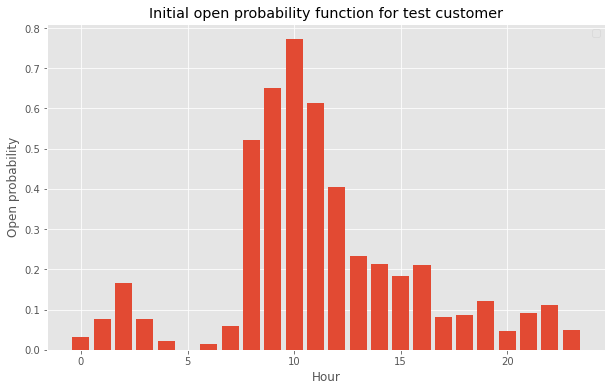

Mean test customer 0.20110925703240753
Total Change 0.13946346337006205


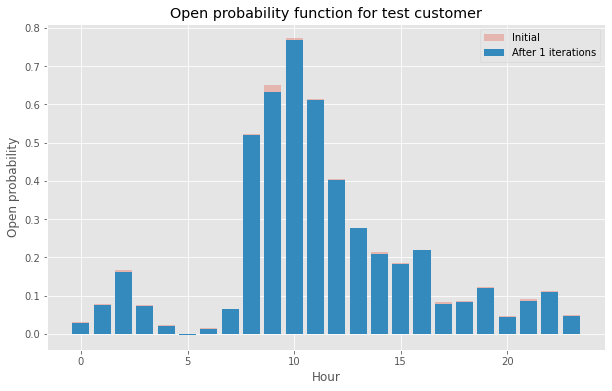

Mean test customer 0.20110925703240745
Total Change 1.7487825996813042


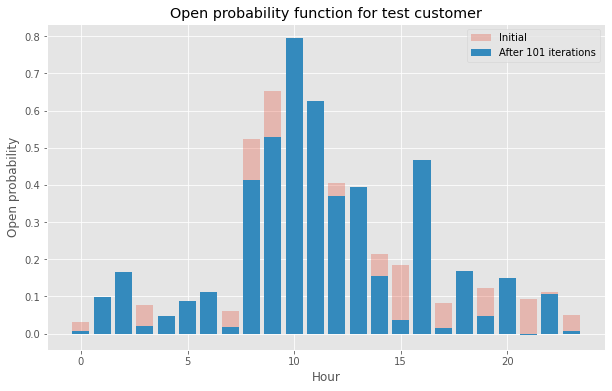

Mean test customer 0.20110925703240753
Total Change 2.8016960969460083


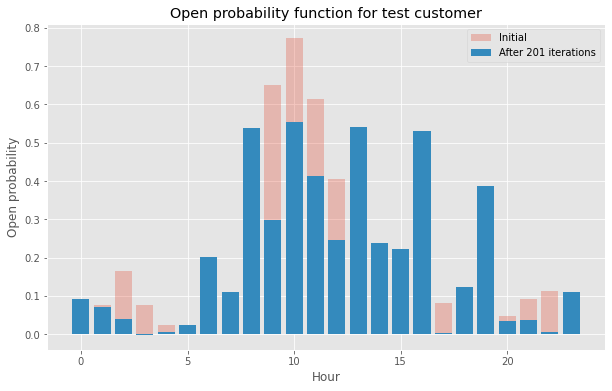

Mean test customer 0.20110925703240756
Total Change 3.732758423461739


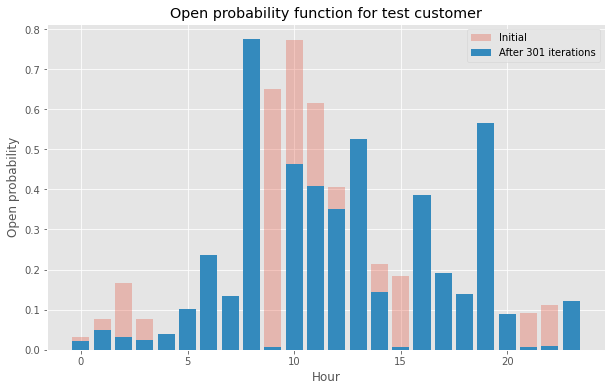

Mean test customer 0.2011092570324078
Total Change 3.36640183470767


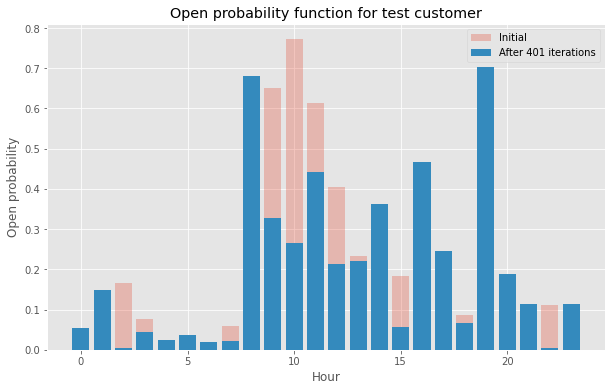

In [209]:
NUMDAYS = 500
customers = [cust for cust in gmm.sample(10)[0]]
env = CustomerBaseFinalForm(customers, 1000, -100, ctp=1, unsub_freq=14)

print("testing morning mailer...")

test_customer_initial = np.clip(env.customer_response_functions[5], 0, 0.8).copy() # We're just picking an arbitrary customer

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(0,24), test_customer_initial)
ax.legend()
ax.set_xlabel("Hour")
ax.set_ylabel("Open probability")
ax.set_title("Initial open probability function for test customer")
plt.show()

for i in range(NUMDAYS):
    todays_rate = 0
    state = env.reset()
    done = False
    total_steps = 0
    while not done:
        total_steps = total_steps + 1
        state, reward, done, opt_out = env.step(state, random.randint(8,11), i)
        if reward > 0 and env.opt_out[state] == 0:
            todays_rate += 1
    if i % 100 == 0 or i == 0:
        print("Mean test customer", np.mean(env.customer_response_functions[5]))
        print("Total Change", np.sum(np.abs(test_customer_initial - env.customer_response_functions[5])))
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(range(0,24), test_customer_initial, label="Initial", alpha=0.3)
        ax.bar(range(0,24), env.customer_response_functions[5], label="After {} iterations".format(i + 1))
        ax.legend()
        ax.set_xlabel("Hour")
        ax.set_ylabel("Open probability")
        ax.set_title("Open probability function for test customer")
        plt.show()
    

### Experiment Setup

In [349]:

class Experiment:
    def __init__(self, agent, customers, days_to_run, initialise_policy,
                 switching_agent, ctp=1, epsilon_tracking = True):
        self.agent = agent
        self.days_to_run = days_to_run
        self.initialise_policy = initialise_policy
        self.switching_agent = switching_agent
        self.epsilon_tracking = epsilon_tracking
        
        # Return values for training
        self.scores = []
        self.num_transitions = 0
        self.response_rate = []
        self.average_epsilon = []
        self.average_reward_for_c = []
        self.response_rate_60_days = 0
        self.target_customer = 100
        
        # Return values for policy testing
        self.results = {
            'scores': [],
            'num_transitions': 0,
            'response_rate': [],
        }
    
        self.env = CustomerBaseFinalForm(customers, 500, -100, ctp=ctp, unsub_freq=14)
        self.policy_history = []

    def train(self):

        print("Training agent...")

        avg_reward = []
        scores = []
        response_rate = []
        reward_for_customer = []

        if self.initialise_policy:
            self.agent.Q[8:11, :] = 1000

        for i in range(self.days_to_run):
            state = 0
            done = False
            responses = 0
            while not done:
                action = self.agent.choose_action(state)
                state_, reward, done, customer_opted_out = self.env.step(
                    state, action, i)
                if self.switching_agent:
                    self.agent.update_Q(
                        (state, action, state_, reward, customer_opted_out, i))
                else:
                    self.agent.update_Q(
                        (state, action, state_, reward, customer_opted_out))
                if self.epsilon_tracking:
                    self.agent.decay_eps(state)
                    reward_for_customer.append(reward)

                state = state_
                avg_reward.append(reward)
                if reward > 0:
                    responses = responses + 1

            # Only calculate the response rate of opted-in customers
            # this does not take into account inactive customers
            if not self.epsilon_tracking:
                self.agent.decay_eps()

            if i % 10 == 0:
                response_rate.append(responses * 100 /
                                     (1000 - np.sum(self.env.opt_out)))
                scores.append(np.mean(avg_reward[:-10]))
                self.average_reward_for_c.append(np.mean(reward_for_customer[:-5]))
                if self.epsilon_tracking:
                    self.average_epsilon.append(np.mean(self.agent.epsilon_array))
                else:
                    self.average_epsilon.append(self.agent.epsilon)
                policy = self.agent.build_policy()
                self.policy_history.append(policy)
                opt_outs = 0
                for value in policy:
                    if value == 24:
                        opt_outs = opt_outs + 1

 
        self.scores = scores
        self.num_transitions = self.env.num_transitions
        self.response_rate = response_rate
        self.response_rate_60_days = response_rate[6]
        print("Customers left:", 1000 - np.sum(self.env.opt_out))
    
    def test(self, trials=1000):
        
        #Make the environment completely static for policy evaluation
        self.env.ctp = 0
        self.env.opt_out_prob = 0
        self.env.prob_inactive = 0

        print("Testing policy...")

        avg_reward = []
        scores = []
        response_rate = []
        eps = []
        reward_for_customer = []
        policy = self.policy_history[-1]

        for i in range(trials):
            state = 0
            done = False
            responses = 0
            while not done:
                action = policy[state]
                state_, reward, done, customer_opted_out = self.env.step(
                    state, action, i)
                # if self.switching_agent:
                #     self.agent.update_Q(
                #         (state, action, state_, reward, customer_opted_out, i))
                # else:
                #     self.agent.update_Q(
                #         (state, action, state_, reward, customer_opted_out))
                # if self.epsilon_tracking:
                #     self.agent.decay_eps(state)
                # else:
                #     self.agent.decay_eps()
                if state == self.target_customer and self.epsilon_tracking:
                    reward_for_customer.append(reward)
                    eps.append(self.agent.epsilon_array[state])
                state = state_
                avg_reward.append(reward)
                if reward > 0:
                    responses = responses + 1

            # Only calculate the response rate of opted-in customers
            # this does not take into account inactive customers

            if i % 10 == 0:
                response_rate.append(responses * 100 /
                                     (1000 - np.sum(self.env.opt_out)))
                scores.append(np.mean(avg_reward[:-10]))
                self.average_reward_for_c.append(np.mean(reward_for_customer[:-5]))
                self.average_epsilon.append(np.mean(eps[:-5]))
                policy = self.agent.build_policy()
                opt_outs = 0
                for value in policy:
                    if value == 24:
                        opt_outs = opt_outs + 1

 
        self.results['scores'] = scores
        self.results['num_transitions'] = self.env.num_transitions
        self.results['response_rate'] = response_rate
    

## Hyperparameter Tuning


### 1. Standard QL

In [294]:
import optuna

customers = [cust for cust in gmm.sample(1000)[0]]
env = CustomerBaseFinalForm(customers, 500, -100, ctp=1, unsub_freq=14)
num_episodes = 365*2

def objective(trial):
    # Define hyperparameter search space
    eps_decay = trial.suggest_float('eps_decay', 0.8, 0.999)
    alpha = trial.suggest_float('alpha', 0.1, 0.9)
    gamma = trial.suggest_float('gamma', 0.5, 0.99)
    
    # Create Q-learning agent with the suggested hyperparameters
    agent = QLearningAgentForFullCustomerBaseWithOpting(
        env,
        eps_start=1.0,
        eps_decay=eps_decay,
        alpha=alpha,
        gamma=gamma
    )
    exp = Experiment(agent, customers, num_episodes, False, False, ctp=1, epsilon_tracking=False)
    exp.train()
    
    return np.mean(exp.response_rate)

# Create an Optuna study for maximizing the average episode reward
study_ql_standard = optuna.create_study(direction='maximize')

# Run the optimization
study_ql_standard.optimize(objective, n_trials=30)  # You can adjust the number of trials as needed

# Get the best hyperparameters
best_params_ql_standard = study_ql_standard.best_params
best_avg_reward_ql_standard = study_ql_standard.best_value

print("Best Hyperparameters:", best_params_ql_standard)
print("Best Average Episode Reward:", best_avg_reward_ql_standard)

[I 2023-10-27 14:44:31,358] A new study created in memory with name: no-name-410f0ac1-ff8d-4ef2-8b6e-d61b288a7159
/Users/abrigrobler/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abrigrobler/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training agent...


[I 2023-10-27 14:45:07,558] Trial 0 finished with value: 37.9150294403785 and parameters: {'eps_decay': 0.961791243524034, 'alpha': 0.2478994736888998, 'gamma': 0.7306450548636696}. Best is trial 0 with value: 37.9150294403785.


Customers left: 860
Training agent...


[I 2023-10-27 14:45:41,955] Trial 1 finished with value: 27.778452159445898 and parameters: {'eps_decay': 0.8059421563529556, 'alpha': 0.5594815671389098, 'gamma': 0.7051064182415543}. Best is trial 0 with value: 37.9150294403785.


Customers left: 879
Training agent...


[I 2023-10-27 14:46:16,365] Trial 2 finished with value: 30.14013505035491 and parameters: {'eps_decay': 0.823263892359994, 'alpha': 0.33043731347672056, 'gamma': 0.8662439975466196}. Best is trial 0 with value: 37.9150294403785.


Customers left: 853
Training agent...


[I 2023-10-27 14:46:50,805] Trial 3 finished with value: 27.52065928550847 and parameters: {'eps_decay': 0.8311746439261075, 'alpha': 0.4848380831147825, 'gamma': 0.5560462939308006}. Best is trial 0 with value: 37.9150294403785.


Customers left: 854
Training agent...


[I 2023-10-27 14:47:25,322] Trial 4 finished with value: 38.523497910461046 and parameters: {'eps_decay': 0.9546916764662805, 'alpha': 0.3234500945114015, 'gamma': 0.503865659043613}. Best is trial 4 with value: 38.523497910461046.


Customers left: 867
Training agent...


[I 2023-10-27 14:47:59,592] Trial 5 finished with value: 28.67270705976546 and parameters: {'eps_decay': 0.826331824697791, 'alpha': 0.4582040723408748, 'gamma': 0.8816451878270604}. Best is trial 4 with value: 38.523497910461046.


Customers left: 869
Training agent...


[I 2023-10-27 14:48:33,922] Trial 6 finished with value: 30.44897543613422 and parameters: {'eps_decay': 0.8217401939483235, 'alpha': 0.4274439434117264, 'gamma': 0.7971556445272564}. Best is trial 4 with value: 38.523497910461046.


Customers left: 843
Training agent...


[I 2023-10-27 14:49:07,963] Trial 7 finished with value: 5.847088108138353 and parameters: {'eps_decay': 0.8624834048884673, 'alpha': 0.8580562485739514, 'gamma': 0.5943462956771367}. Best is trial 4 with value: 38.523497910461046.


Customers left: 872
Training agent...


[I 2023-10-27 14:49:42,269] Trial 8 finished with value: 32.50901732322424 and parameters: {'eps_decay': 0.8115659633685892, 'alpha': 0.19616851000712476, 'gamma': 0.822126020184102}. Best is trial 4 with value: 38.523497910461046.


Customers left: 860
Training agent...


[I 2023-10-27 14:50:17,010] Trial 9 finished with value: 36.11517442876905 and parameters: {'eps_decay': 0.9680031224119711, 'alpha': 0.48752196421762806, 'gamma': 0.8362171055871441}. Best is trial 4 with value: 38.523497910461046.


Customers left: 873
Training agent...


[I 2023-10-27 14:50:51,520] Trial 10 finished with value: 38.45888413365184 and parameters: {'eps_decay': 0.9337319153304079, 'alpha': 0.17373334816079167, 'gamma': 0.50651183584481}. Best is trial 4 with value: 38.523497910461046.


Customers left: 853
Training agent...


[I 2023-10-27 14:51:26,264] Trial 11 finished with value: 38.45703993392174 and parameters: {'eps_decay': 0.9292273499015679, 'alpha': 0.11551278126813638, 'gamma': 0.5022134684420884}. Best is trial 4 with value: 38.523497910461046.


Customers left: 859
Training agent...


[I 2023-10-27 14:52:03,033] Trial 12 finished with value: 40.329166675978016 and parameters: {'eps_decay': 0.9960967867115734, 'alpha': 0.14981331946287213, 'gamma': 0.628296220833727}. Best is trial 12 with value: 40.329166675978016.


Customers left: 847
Training agent...


[I 2023-10-27 14:52:40,764] Trial 13 finished with value: 33.318275126623234 and parameters: {'eps_decay': 0.997884715254316, 'alpha': 0.10680776125162642, 'gamma': 0.6261634771452521}. Best is trial 12 with value: 40.329166675978016.


Customers left: 860
Training agent...


[I 2023-10-27 14:53:15,670] Trial 14 finished with value: 42.61666284294117 and parameters: {'eps_decay': 0.9814252021172749, 'alpha': 0.29823164517780054, 'gamma': 0.6568908084476692}. Best is trial 14 with value: 42.61666284294117.


Customers left: 857
Training agent...


[I 2023-10-27 14:53:50,915] Trial 15 finished with value: 43.315650072557254 and parameters: {'eps_decay': 0.991240770282724, 'alpha': 0.26708197612644013, 'gamma': 0.6569476582105663}. Best is trial 15 with value: 43.315650072557254.


Customers left: 853
Training agent...


[I 2023-10-27 14:54:25,297] Trial 16 finished with value: 30.943532555553652 and parameters: {'eps_decay': 0.8973642564106009, 'alpha': 0.31474389201359115, 'gamma': 0.9529230003133048}. Best is trial 15 with value: 43.315650072557254.


Customers left: 852
Training agent...


[I 2023-10-27 14:55:00,096] Trial 17 finished with value: 41.60075119375279 and parameters: {'eps_decay': 0.9765933647218781, 'alpha': 0.23332434166983748, 'gamma': 0.7034793545035515}. Best is trial 15 with value: 43.315650072557254.


Customers left: 876
Training agent...


[I 2023-10-27 14:55:34,950] Trial 18 finished with value: 39.62999268933504 and parameters: {'eps_decay': 0.9831857417263725, 'alpha': 0.37965562648907736, 'gamma': 0.663406946502487}. Best is trial 15 with value: 43.315650072557254.


Customers left: 844
Training agent...


[I 2023-10-27 14:56:09,465] Trial 19 finished with value: 36.273885706449995 and parameters: {'eps_decay': 0.9495714530272953, 'alpha': 0.26902044516225193, 'gamma': 0.7607744366371967}. Best is trial 15 with value: 43.315650072557254.


Customers left: 864
Training agent...


[I 2023-10-27 14:56:44,354] Trial 20 finished with value: 29.43605157295159 and parameters: {'eps_decay': 0.9820538912129508, 'alpha': 0.5781182435129433, 'gamma': 0.6811283618650926}. Best is trial 15 with value: 43.315650072557254.


Customers left: 853
Training agent...


[I 2023-10-27 14:57:19,138] Trial 21 finished with value: 41.09347974574468 and parameters: {'eps_decay': 0.9779776169440613, 'alpha': 0.23488321028779552, 'gamma': 0.7099120770848272}. Best is trial 15 with value: 43.315650072557254.


Customers left: 846
Training agent...


[I 2023-10-27 14:57:56,360] Trial 22 finished with value: 39.49305890960346 and parameters: {'eps_decay': 0.9959798390324689, 'alpha': 0.21708357723907962, 'gamma': 0.6704585924578911}. Best is trial 15 with value: 43.315650072557254.


Customers left: 857
Training agent...


[I 2023-10-27 14:58:31,454] Trial 23 finished with value: 40.114404793801604 and parameters: {'eps_decay': 0.9734262414139251, 'alpha': 0.37522928896226065, 'gamma': 0.7428252762061174}. Best is trial 15 with value: 43.315650072557254.


Customers left: 852
Training agent...


[I 2023-10-27 14:59:05,871] Trial 24 finished with value: 38.231846060679054 and parameters: {'eps_decay': 0.9398064208718435, 'alpha': 0.2735578782912629, 'gamma': 0.6381425933254996}. Best is trial 15 with value: 43.315650072557254.


Customers left: 884
Training agent...


[I 2023-10-27 14:59:40,257] Trial 25 finished with value: 40.520608601613 and parameters: {'eps_decay': 0.9632912462594487, 'alpha': 0.17279034804157714, 'gamma': 0.5861267778116197}. Best is trial 15 with value: 43.315650072557254.


Customers left: 864
Training agent...


[I 2023-10-27 15:00:14,510] Trial 26 finished with value: 36.183316943119415 and parameters: {'eps_decay': 0.9191757662757947, 'alpha': 0.10271051067771272, 'gamma': 0.6941849418674134}. Best is trial 15 with value: 43.315650072557254.


Customers left: 853
Training agent...


[I 2023-10-27 15:00:48,897] Trial 27 finished with value: 37.59304718800546 and parameters: {'eps_decay': 0.9507765315612832, 'alpha': 0.21303208014685077, 'gamma': 0.7518429106208927}. Best is trial 15 with value: 43.315650072557254.


Customers left: 848
Training agent...


[I 2023-10-27 15:01:23,756] Trial 28 finished with value: 42.60706805877617 and parameters: {'eps_decay': 0.9800029288917464, 'alpha': 0.28359694839001504, 'gamma': 0.6593919371744486}. Best is trial 15 with value: 43.315650072557254.


Customers left: 852
Training agent...


[I 2023-10-27 15:01:58,227] Trial 29 finished with value: 41.541383463684106 and parameters: {'eps_decay': 0.9680121257019818, 'alpha': 0.28129708461091835, 'gamma': 0.6566034465582185}. Best is trial 15 with value: 43.315650072557254.


Customers left: 865
Best Hyperparameters: {'eps_decay': 0.991240770282724, 'alpha': 0.26708197612644013, 'gamma': 0.6569476582105663}
Best Average Episode Reward: 43.315650072557254


<ipython-input-295-f1082cb660e3>:15: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_ql_standard)
<ipython-input-295-f1082cb660e3>:16: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study_ql_standard)
[W 2023-10-27 15:01:58,361] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
<ipython-input-295-f1082cb660e3>:17: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study_ql_standard)


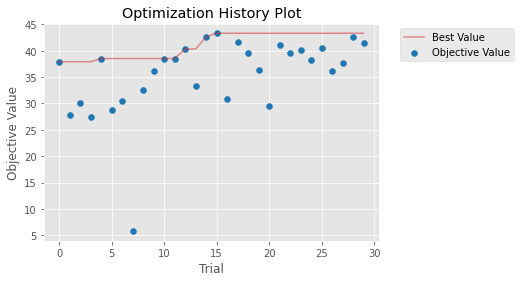

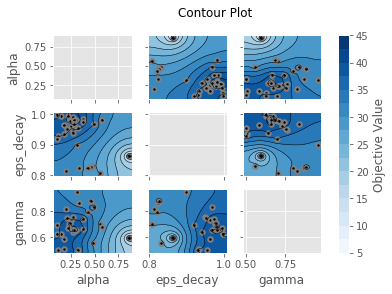

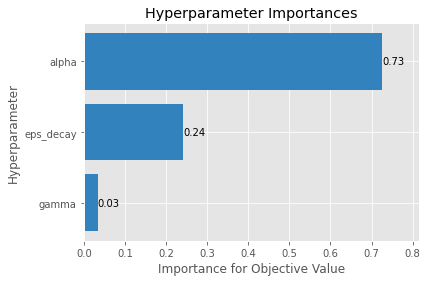

In [295]:
from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_rank
from optuna.visualization.matplotlib import plot_slice
from optuna.visualization.matplotlib import plot_timeline

SEED = 42

np.random.seed(SEED)
plt.figsize = (20, 10)
plot_optimization_history(study_ql_standard)
plot_contour(study_ql_standard)
plot_param_importances(study_ql_standard)
plt.show()

### 2. QL with TAE

In [296]:
customers = [cust for cust in gmm.sample(1000)[0]]
env = CustomerBaseFinalForm(customers, 500, -100, ctp=1, unsub_freq=14)
num_episodes = 365*2

def objective(trial):
    # Define hyperparameter search space
    eps_decay = trial.suggest_float('eps_decay', 0.8, 0.999)
    alpha = trial.suggest_float('alpha', 0.1, 0.9)
    gamma = trial.suggest_float('gamma', 0.5, 0.99)
    eps_max = trial.suggest_float('eps_max', 0.2, 0.8)
    
    # Create Q-learning agent with the suggested hyperparameters
    agent = QLA_EPSILON_TRACKING(
        env,
        eps_start=1.0,
        eps_decay=eps_decay,
        alpha=alpha,
        gamma=gamma,
        eps_max=eps_max
    )
    exp = Experiment(agent, customers, num_episodes, False, False, ctp=1, epsilon_tracking=True)
    exp.train()
    
    return np.mean(exp.response_rate)

# Create an Optuna study for maximizing the average episode reward
study_ql_aug = optuna.create_study(direction='maximize')

# Run the optimization
study_ql_aug.optimize(objective, n_trials=30)  # You can adjust the number of trials as needed

# Get the best hyperparameters
best_params_ql_aug = study_ql_aug.best_params
best_avg_reward_ql_aug = study_ql_aug.best_value

print("Best Hyperparameters:", best_params_ql_aug)
print("Best Average Episode Reward:", best_avg_reward_ql_aug)

[I 2023-10-27 15:02:01,564] A new study created in memory with name: no-name-a81d6398-419d-419b-93f4-d0595dd60745


Training agent...


[I 2023-10-27 15:02:40,122] Trial 0 finished with value: 30.41509744562646 and parameters: {'eps_decay': 0.8128877227897673, 'alpha': 0.5640674978099861, 'gamma': 0.8783947940919503, 'eps_max': 0.4427968885435971}. Best is trial 0 with value: 30.41509744562646.


Customers left: 856
Training agent...


[I 2023-10-27 15:03:20,580] Trial 1 finished with value: 23.474506621118618 and parameters: {'eps_decay': 0.940951149195508, 'alpha': 0.849293660828759, 'gamma': 0.7287766706731367, 'eps_max': 0.47610818041213065}. Best is trial 0 with value: 30.41509744562646.


Customers left: 855
Training agent...


[I 2023-10-27 15:03:59,397] Trial 2 finished with value: 27.474589845433318 and parameters: {'eps_decay': 0.8547581230345606, 'alpha': 0.6176939380601836, 'gamma': 0.8272646490380056, 'eps_max': 0.44725452517610453}. Best is trial 0 with value: 30.41509744562646.


Customers left: 866
Training agent...


[I 2023-10-27 15:04:37,767] Trial 3 finished with value: 30.7188049915066 and parameters: {'eps_decay': 0.8783822594742617, 'alpha': 0.5554662910366447, 'gamma': 0.9444566072024196, 'eps_max': 0.2682514583157788}. Best is trial 3 with value: 30.7188049915066.


Customers left: 855
Training agent...


[I 2023-10-27 15:05:16,710] Trial 4 finished with value: 33.652544470335705 and parameters: {'eps_decay': 0.8516939701657777, 'alpha': 0.4410691539463113, 'gamma': 0.8863641209092117, 'eps_max': 0.5290080674601083}. Best is trial 4 with value: 33.652544470335705.


Customers left: 862
Training agent...


[I 2023-10-27 15:05:57,555] Trial 5 finished with value: 30.337825129239175 and parameters: {'eps_decay': 0.9736034071334536, 'alpha': 0.4789337668000987, 'gamma': 0.5032894817313842, 'eps_max': 0.5460528648396562}. Best is trial 4 with value: 33.652544470335705.


Customers left: 836
Training agent...


[I 2023-10-27 15:06:39,680] Trial 6 finished with value: 25.333895391667056 and parameters: {'eps_decay': 0.9810876274320639, 'alpha': 0.4640442839035087, 'gamma': 0.8693711724262658, 'eps_max': 0.7421454063869095}. Best is trial 4 with value: 33.652544470335705.


Customers left: 842
Training agent...


[I 2023-10-27 15:07:18,949] Trial 7 finished with value: 35.483882584645315 and parameters: {'eps_decay': 0.9609468307873134, 'alpha': 0.2221606116700884, 'gamma': 0.8880661454973962, 'eps_max': 0.334769859885712}. Best is trial 7 with value: 35.483882584645315.


Customers left: 831
Training agent...


[I 2023-10-27 15:07:56,586] Trial 8 finished with value: 27.770010840893537 and parameters: {'eps_decay': 0.8477878984244535, 'alpha': 0.5606795181754717, 'gamma': 0.625928343828377, 'eps_max': 0.2343021709525311}. Best is trial 7 with value: 35.483882584645315.


Customers left: 850
Training agent...


[I 2023-10-27 15:08:39,250] Trial 9 finished with value: 26.078377177485145 and parameters: {'eps_decay': 0.9923285836350403, 'alpha': 0.3594952718021761, 'gamma': 0.7524364387946929, 'eps_max': 0.7192669248989412}. Best is trial 7 with value: 35.483882584645315.


Customers left: 852
Training agent...


[I 2023-10-27 15:09:21,719] Trial 10 finished with value: 30.674987044502373 and parameters: {'eps_decay': 0.9257908495466874, 'alpha': 0.10372357316454939, 'gamma': 0.9857329009753363, 'eps_max': 0.30872149281735184}. Best is trial 7 with value: 35.483882584645315.


Customers left: 880
Training agent...


[I 2023-10-27 15:10:01,200] Trial 11 finished with value: 33.45235675770106 and parameters: {'eps_decay': 0.8994586968139109, 'alpha': 0.2236723752203486, 'gamma': 0.9265607326143019, 'eps_max': 0.359169523843337}. Best is trial 7 with value: 35.483882584645315.


Customers left: 880
Training agent...


[I 2023-10-27 15:10:42,186] Trial 12 finished with value: 29.57665102967764 and parameters: {'eps_decay': 0.9413034306805672, 'alpha': 0.3122384171868021, 'gamma': 0.9888476085997013, 'eps_max': 0.5821936200394985}. Best is trial 7 with value: 35.483882584645315.


Customers left: 870
Training agent...


[I 2023-10-27 15:11:21,487] Trial 13 finished with value: 34.871215531213885 and parameters: {'eps_decay': 0.9147690735542924, 'alpha': 0.11413675836231407, 'gamma': 0.8065643588755365, 'eps_max': 0.36533357789797816}. Best is trial 7 with value: 35.483882584645315.


Customers left: 857
Training agent...


[I 2023-10-27 15:12:00,102] Trial 14 finished with value: 35.486774780205266 and parameters: {'eps_decay': 0.9540460691386409, 'alpha': 0.11368148618390372, 'gamma': 0.8026325281703485, 'eps_max': 0.2041963183306504}. Best is trial 14 with value: 35.486774780205266.


Customers left: 870
Training agent...


[I 2023-10-27 15:12:38,570] Trial 15 finished with value: 39.54519899465742 and parameters: {'eps_decay': 0.9570582391124289, 'alpha': 0.22198915064366515, 'gamma': 0.7863846472771775, 'eps_max': 0.20494555697560116}. Best is trial 15 with value: 39.54519899465742.


Customers left: 863
Training agent...


[I 2023-10-27 15:13:17,007] Trial 16 finished with value: 39.30822108197299 and parameters: {'eps_decay': 0.9575518731326278, 'alpha': 0.1985087856021484, 'gamma': 0.7323731725163715, 'eps_max': 0.2006389953960673}. Best is trial 15 with value: 39.54519899465742.


Customers left: 859
Training agent...


[I 2023-10-27 15:13:55,454] Trial 17 finished with value: 41.998753997734624 and parameters: {'eps_decay': 0.9706799418910828, 'alpha': 0.2637725804923637, 'gamma': 0.6912528938256348, 'eps_max': 0.2020749000859965}. Best is trial 17 with value: 41.998753997734624.


Customers left: 844
Training agent...


[I 2023-10-27 15:14:34,684] Trial 18 finished with value: 39.066729979275514 and parameters: {'eps_decay': 0.9881812394232212, 'alpha': 0.33794571231233156, 'gamma': 0.6761487284260942, 'eps_max': 0.2647622455798687}. Best is trial 17 with value: 41.998753997734624.


Customers left: 854
Training agent...


[I 2023-10-27 15:15:15,066] Trial 19 finished with value: 30.270542880882825 and parameters: {'eps_decay': 0.9982703001461363, 'alpha': 0.279571521872311, 'gamma': 0.6493782055332149, 'eps_max': 0.3025222799900037}. Best is trial 17 with value: 41.998753997734624.


Customers left: 860
Training agent...


[I 2023-10-27 15:15:54,595] Trial 20 finished with value: 35.49207368996591 and parameters: {'eps_decay': 0.9703515997707063, 'alpha': 0.381836861941641, 'gamma': 0.768811574616245, 'eps_max': 0.3859417252617322}. Best is trial 17 with value: 41.998753997734624.


Customers left: 843
Training agent...


[I 2023-10-27 15:16:33,067] Trial 21 finished with value: 41.11546979056873 and parameters: {'eps_decay': 0.9510722530969757, 'alpha': 0.2343318909444654, 'gamma': 0.7053475188210474, 'eps_max': 0.20908003381905715}. Best is trial 17 with value: 41.998753997734624.


Customers left: 862
Training agent...


[I 2023-10-27 15:17:11,939] Trial 22 finished with value: 40.10929265212176 and parameters: {'eps_decay': 0.9412252258617676, 'alpha': 0.262493790938778, 'gamma': 0.7033487843353132, 'eps_max': 0.2526863800211725}. Best is trial 17 with value: 41.998753997734624.


Customers left: 885
Training agent...


[I 2023-10-27 15:17:50,701] Trial 23 finished with value: 39.181998778340834 and parameters: {'eps_decay': 0.9377536378533539, 'alpha': 0.2868140803041691, 'gamma': 0.694265156270949, 'eps_max': 0.2699719315597542}. Best is trial 17 with value: 41.998753997734624.


Customers left: 861
Training agent...


[I 2023-10-27 15:18:29,859] Trial 24 finished with value: 38.58157394308243 and parameters: {'eps_decay': 0.9760988194529849, 'alpha': 0.3964432946961683, 'gamma': 0.615424994052286, 'eps_max': 0.2536233334595277}. Best is trial 17 with value: 41.998753997734624.


Customers left: 851
Training agent...


[I 2023-10-27 15:19:08,845] Trial 25 finished with value: 38.34095497235939 and parameters: {'eps_decay': 0.9243199573899192, 'alpha': 0.17148566266518, 'gamma': 0.7215692591299049, 'eps_max': 0.3088807130952432}. Best is trial 17 with value: 41.998753997734624.


Customers left: 853
Training agent...


[I 2023-10-27 15:19:47,579] Trial 26 finished with value: 40.18148585278922 and parameters: {'eps_decay': 0.9495315407742808, 'alpha': 0.2951341397714662, 'gamma': 0.6828113106345552, 'eps_max': 0.23710649031720768}. Best is trial 17 with value: 41.998753997734624.


Customers left: 866
Training agent...


[I 2023-10-27 15:20:26,325] Trial 27 finished with value: 41.29562361582623 and parameters: {'eps_decay': 0.9713539101551315, 'alpha': 0.30926798360047814, 'gamma': 0.6679490551880454, 'eps_max': 0.20128080438642681}. Best is trial 17 with value: 41.998753997734624.


Customers left: 865
Training agent...


[I 2023-10-27 15:21:05,291] Trial 28 finished with value: 42.226659011277675 and parameters: {'eps_decay': 0.9668912169088064, 'alpha': 0.16785358603428363, 'gamma': 0.5797208559770299, 'eps_max': 0.20067003886346693}. Best is trial 28 with value: 42.226659011277675.


Customers left: 867
Training agent...


[I 2023-10-27 15:21:45,590] Trial 29 finished with value: 37.59829124716505 and parameters: {'eps_decay': 0.9853384085112787, 'alpha': 0.1672717266314507, 'gamma': 0.6006661032152014, 'eps_max': 0.3961748310427944}. Best is trial 28 with value: 42.226659011277675.


Customers left: 858
Best Hyperparameters: {'eps_decay': 0.9668912169088064, 'alpha': 0.16785358603428363, 'gamma': 0.5797208559770299, 'eps_max': 0.20067003886346693}
Best Average Episode Reward: 42.226659011277675


<ipython-input-297-2adab61ffeec>:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_ql_aug)
<ipython-input-297-2adab61ffeec>:3: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study_ql_aug)
[W 2023-10-27 15:21:45,669] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


<ipython-input-297-2adab61ffeec>:4: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study_ql_aug)


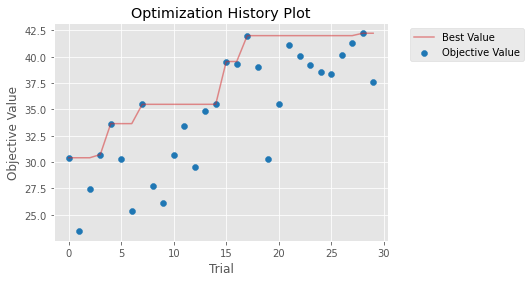

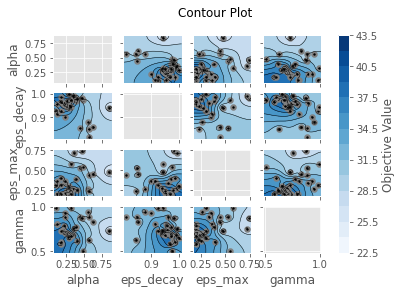

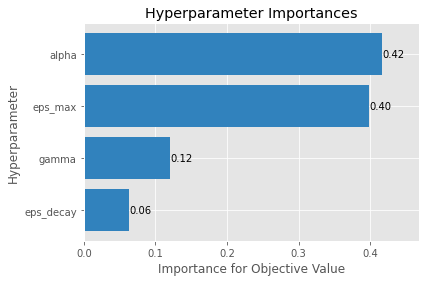

In [297]:
plt.figsize = (20, 10)
plot_optimization_history(study_ql_aug)
plot_contour(study_ql_aug)
plot_param_importances(study_ql_aug)
plt.show()

### 3. RUQL with standard exploration

In [298]:
customers = [cust for cust in gmm.sample(1000)[0]]
env = CustomerBaseFinalForm(customers, 500, -100, ctp=1, unsub_freq=14)
num_episodes = 365*2

def objective(trial):
    # Define hyperparameter search space
    eps_decay = trial.suggest_float('eps_decay', 0.8, 0.999)
    alpha = trial.suggest_float('alpha', 0.1, 0.9)
    gamma = trial.suggest_float('gamma', 0.5, 0.99)
    
    # Create Q-learning agent with the suggested hyperparameters
    agent = RUQLA(
        env,
        eps_start=1.0,
        eps_decay=eps_decay,
        alpha=alpha,
        gamma=gamma
    )
    exp = Experiment(agent, customers, num_episodes, False, False, ctp=1, epsilon_tracking=False)
    exp.train()
    
    return np.mean(exp.response_rate)

# Create an Optuna study for maximizing the average episode reward
study_ruql_standard = optuna.create_study(direction='maximize')

# Run the optimization
study_ruql_standard.optimize(objective, n_trials=30)  # You can adjust the number of trials as needed

# Get the best hyperparameters
best_params_ruql_standard = study_ruql_standard.best_params
best_avg_reward_ruql_standard = study_ruql_standard.best_value

print("Best Hyperparameters:", best_params_ruql_standard)
print("Best Average Episode Reward:", best_avg_reward_ruql_standard)

[I 2023-10-27 15:21:47,763] A new study created in memory with name: no-name-a1a4418a-9f7e-40c5-a212-47f2b9be444c


/Users/abrigrobler/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abrigrobler/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Training agent...


[I 2023-10-27 15:22:25,416] Trial 0 finished with value: 42.65509824437268 and parameters: {'eps_decay': 0.98937970954254, 'alpha': 0.1730828066171907, 'gamma': 0.6816492935480644}. Best is trial 0 with value: 42.65509824437268.


Customers left: 857
Training agent...


[I 2023-10-27 15:23:01,715] Trial 1 finished with value: 29.082016681328216 and parameters: {'eps_decay': 0.9298696448066537, 'alpha': 0.4434269649489866, 'gamma': 0.528858508330032}. Best is trial 0 with value: 42.65509824437268.


Customers left: 855
Training agent...


[I 2023-10-27 15:23:37,829] Trial 2 finished with value: 23.689855266051232 and parameters: {'eps_decay': 0.8251598012883695, 'alpha': 0.7158983038786005, 'gamma': 0.9277005366066284}. Best is trial 0 with value: 42.65509824437268.


Customers left: 847
Training agent...


[I 2023-10-27 15:24:14,807] Trial 3 finished with value: 40.26040284906549 and parameters: {'eps_decay': 0.964965460533475, 'alpha': 0.19696136776550877, 'gamma': 0.6372457615354257}. Best is trial 0 with value: 42.65509824437268.


Customers left: 869
Training agent...


[I 2023-10-27 15:24:50,887] Trial 4 finished with value: 16.002251566540977 and parameters: {'eps_decay': 0.9019866983363275, 'alpha': 0.7424076313119141, 'gamma': 0.6212768211196174}. Best is trial 0 with value: 42.65509824437268.


Customers left: 852
Training agent...


[I 2023-10-27 15:25:27,142] Trial 5 finished with value: 32.67196131035216 and parameters: {'eps_decay': 0.9080065279600383, 'alpha': 0.45016903064569813, 'gamma': 0.6749866997703616}. Best is trial 0 with value: 42.65509824437268.


Customers left: 873
Training agent...


[I 2023-10-27 15:26:03,383] Trial 6 finished with value: 33.665525854587216 and parameters: {'eps_decay': 0.9246457952506923, 'alpha': 0.20245222838699536, 'gamma': 0.8222840738230024}. Best is trial 0 with value: 42.65509824437268.


Customers left: 858
Training agent...


[I 2023-10-27 15:26:39,506] Trial 7 finished with value: 31.539018773300327 and parameters: {'eps_decay': 0.8796465316406472, 'alpha': 0.20485065068570424, 'gamma': 0.9006555047486009}. Best is trial 0 with value: 42.65509824437268.


Customers left: 849
Training agent...


[I 2023-10-27 15:27:15,856] Trial 8 finished with value: 39.22740009657047 and parameters: {'eps_decay': 0.9664788191902249, 'alpha': 0.2733056751612536, 'gamma': 0.7991824130271843}. Best is trial 0 with value: 42.65509824437268.


Customers left: 851
Training agent...


[I 2023-10-27 15:27:52,004] Trial 9 finished with value: 16.391649203666603 and parameters: {'eps_decay': 0.9498289203490123, 'alpha': 0.8326458259001436, 'gamma': 0.7009381006236615}. Best is trial 0 with value: 42.65509824437268.


Customers left: 865
Training agent...


[I 2023-10-27 15:28:29,939] Trial 10 finished with value: 37.85143699035398 and parameters: {'eps_decay': 0.9944952665509773, 'alpha': 0.1129575685993165, 'gamma': 0.7652343427615801}. Best is trial 0 with value: 42.65509824437268.


Customers left: 882
Training agent...


[I 2023-10-27 15:29:07,017] Trial 11 finished with value: 40.82369805706909 and parameters: {'eps_decay': 0.9905424326993224, 'alpha': 0.10201547970470304, 'gamma': 0.6042227371224292}. Best is trial 0 with value: 42.65509824437268.


Customers left: 855
Training agent...


[I 2023-10-27 15:29:43,962] Trial 12 finished with value: 39.86314733159111 and parameters: {'eps_decay': 0.9885076893717214, 'alpha': 0.3427773165824124, 'gamma': 0.5633141604760047}. Best is trial 0 with value: 42.65509824437268.


Customers left: 864
Training agent...


[I 2023-10-27 15:30:22,241] Trial 13 finished with value: 39.60119902427112 and parameters: {'eps_decay': 0.9960026035494698, 'alpha': 0.1360669136028151, 'gamma': 0.600370848938117}. Best is trial 0 with value: 42.65509824437268.


Customers left: 864
Training agent...


[I 2023-10-27 15:30:58,733] Trial 14 finished with value: 39.64783466535392 and parameters: {'eps_decay': 0.9635008012662549, 'alpha': 0.10117441018121408, 'gamma': 0.5088198704119238}. Best is trial 0 with value: 42.65509824437268.


Customers left: 865
Training agent...


[I 2023-10-27 15:31:37,492] Trial 15 finished with value: 34.79736929860724 and parameters: {'eps_decay': 0.9970788588588811, 'alpha': 0.3306610968090618, 'gamma': 0.7027405766112984}. Best is trial 0 with value: 42.65509824437268.


Customers left: 854
Training agent...


[I 2023-10-27 15:32:13,728] Trial 16 finished with value: 23.134509961509096 and parameters: {'eps_decay': 0.9435178751623906, 'alpha': 0.56733646536151, 'gamma': 0.5791705849668234}. Best is trial 0 with value: 42.65509824437268.


Customers left: 861
Training agent...


[I 2023-10-27 15:32:50,031] Trial 17 finished with value: 39.45390171548509 and parameters: {'eps_decay': 0.9649808867460137, 'alpha': 0.3122022967002932, 'gamma': 0.6555309125374911}. Best is trial 0 with value: 42.65509824437268.


Customers left: 840
Training agent...


[I 2023-10-27 15:33:26,750] Trial 18 finished with value: 40.715855946978415 and parameters: {'eps_decay': 0.9820026280950059, 'alpha': 0.2451218735820805, 'gamma': 0.7367895467496398}. Best is trial 0 with value: 42.65509824437268.


Customers left: 852
Training agent...


[I 2023-10-27 15:34:03,317] Trial 19 finished with value: 37.43944437309309 and parameters: {'eps_decay': 0.9766446429516604, 'alpha': 0.3806807910314754, 'gamma': 0.5613868333211227}. Best is trial 0 with value: 42.65509824437268.


Customers left: 865
Training agent...


[I 2023-10-27 15:34:39,638] Trial 20 finished with value: 37.55576703873234 and parameters: {'eps_decay': 0.9360880702759271, 'alpha': 0.1675174238852894, 'gamma': 0.6377709154007051}. Best is trial 0 with value: 42.65509824437268.


Customers left: 842
Training agent...


[I 2023-10-27 15:35:16,366] Trial 21 finished with value: 40.96436383865781 and parameters: {'eps_decay': 0.9798238765163352, 'alpha': 0.21973623727519154, 'gamma': 0.7330335554834678}. Best is trial 0 with value: 42.65509824437268.


Customers left: 848
Training agent...


[I 2023-10-27 15:35:52,838] Trial 22 finished with value: 41.79857492518387 and parameters: {'eps_decay': 0.9755822484862922, 'alpha': 0.25602500794141514, 'gamma': 0.6983224277204522}. Best is trial 0 with value: 42.65509824437268.


Customers left: 843
Training agent...


[I 2023-10-27 15:36:29,159] Trial 23 finished with value: 37.319974172018824 and parameters: {'eps_decay': 0.9491781172395256, 'alpha': 0.2203301136446832, 'gamma': 0.7355163524978875}. Best is trial 0 with value: 42.65509824437268.


Customers left: 873
Training agent...


[I 2023-10-27 15:37:05,711] Trial 24 finished with value: 41.86775539763551 and parameters: {'eps_decay': 0.9766048532987538, 'alpha': 0.2733806246086562, 'gamma': 0.6934942154499191}. Best is trial 0 with value: 42.65509824437268.


Customers left: 849
Training agent...


[I 2023-10-27 15:37:42,388] Trial 25 finished with value: 41.2958947527463 and parameters: {'eps_decay': 0.9742384762242456, 'alpha': 0.2746637353186644, 'gamma': 0.6879229059241242}. Best is trial 0 with value: 42.65509824437268.


Customers left: 840
Training agent...


[I 2023-10-27 15:38:18,791] Trial 26 finished with value: 38.39851943299281 and parameters: {'eps_decay': 0.9536862266374978, 'alpha': 0.2728016389428207, 'gamma': 0.6572282933427611}. Best is trial 0 with value: 42.65509824437268.


Customers left: 855
Training agent...


[I 2023-10-27 15:38:56,220] Trial 27 finished with value: 39.88133975916481 and parameters: {'eps_decay': 0.9801134869692223, 'alpha': 0.37970849131254375, 'gamma': 0.701385866622189}. Best is trial 0 with value: 42.65509824437268.


Customers left: 870
Training agent...


[I 2023-10-27 15:39:33,251] Trial 28 finished with value: 36.76189712632984 and parameters: {'eps_decay': 0.9576932624504416, 'alpha': 0.15832800224324117, 'gamma': 0.7774667843854346}. Best is trial 0 with value: 42.65509824437268.


Customers left: 852
Training agent...


[I 2023-10-27 15:40:09,485] Trial 29 finished with value: 29.87576649106156 and parameters: {'eps_decay': 0.9351701288618902, 'alpha': 0.4554944740348166, 'gamma': 0.5408508185442583}. Best is trial 0 with value: 42.65509824437268.


Customers left: 842
Best Hyperparameters: {'eps_decay': 0.98937970954254, 'alpha': 0.1730828066171907, 'gamma': 0.6816492935480644}
Best Average Episode Reward: 42.65509824437268


<ipython-input-299-2f83f5863a4a>:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_ruql_standard)
<ipython-input-299-2f83f5863a4a>:3: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study_ruql_standard)
[W 2023-10-27 15:40:09,583] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
<ipython-input-299-2f83f5863a4a>:4: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study_ruql_standard)


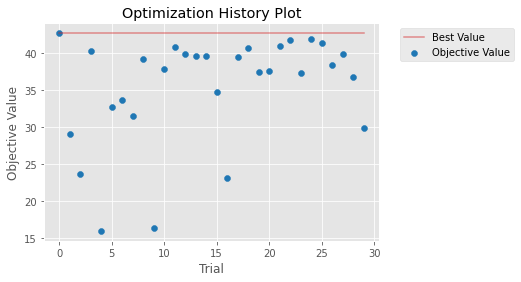

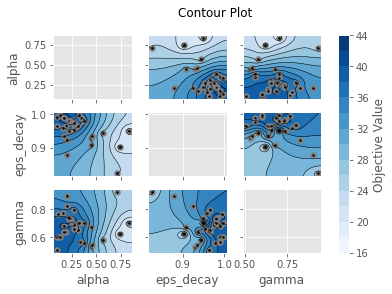

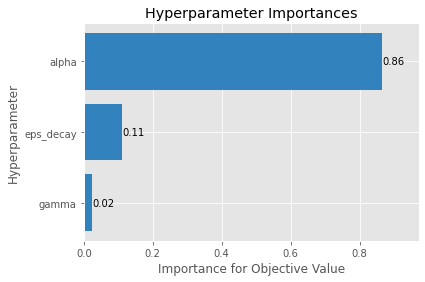

In [299]:
plt.figsize = (20, 10)
plot_optimization_history(study_ruql_standard)
plot_contour(study_ruql_standard)
plot_param_importances(study_ruql_standard)
plt.show()

### 4. RUQL with augmented exploration

In [414]:
customers = [cust for cust in gmm.sample(1000)[0]]
env = CustomerBaseFinalForm(customers, 500, -100, ctp=1, unsub_freq=14)
num_episodes = 365*2

def objective(trial):
    # Define hyperparameter search space
    eps_decay = trial.suggest_float('eps_decay', 0.8, 0.999)
    alpha = trial.suggest_float('alpha', 0.1, 0.9)
    gamma = trial.suggest_float('gamma', 0.5, 0.99)
    eps_max = trial.suggest_float('eps_max', 0.2, 0.8)
    
    # Create Q-learning agent with the suggested hyperparameters
    agent = RUQLA_EPSILON_TRACKING(
        env,
        eps_start=1.0,
        eps_decay=eps_decay,
        alpha=alpha,
        gamma=gamma,
        eps_max=eps_max
    )
    exp = Experiment(agent, customers, num_episodes, False, False, ctp=1, epsilon_tracking=True)
    exp.train()
    
    return np.mean(exp.response_rate)

# Create an Optuna study for maximizing the average episode reward
study_ruql_augment = optuna.create_study(direction='maximize')

# Run the optimization
study_ruql_augment.optimize(objective, n_trials=30)  # You can adjust the number of trials as needed

# Get the best hyperparameters
best_params_ruql_augment = study_ruql_augment.best_params
best_avg_reward_ruql_augment = study_ruql_augment.best_value

print("Best Hyperparameters:", best_params_ruql_augment)
print("Best Average Episode Reward:", best_avg_reward_ruql_augment)

[I 2023-10-30 21:42:11,583] A new study created in memory with name: no-name-617e7f8e-79b1-467d-8dd8-81f4a5ee152e


Training agent...


[I 2023-10-30 21:42:55,921] Trial 0 finished with value: 25.907476092121698 and parameters: {'eps_decay': 0.9938587561238846, 'alpha': 0.5387603758946232, 'gamma': 0.5248489282952201, 'eps_max': 0.6596447135462693}. Best is trial 0 with value: 25.907476092121698.


Customers left: 858
Training agent...


[I 2023-10-30 21:43:35,865] Trial 1 finished with value: 28.53410985533915 and parameters: {'eps_decay': 0.9152986532698387, 'alpha': 0.6214702823543743, 'gamma': 0.7915929886276037, 'eps_max': 0.2617916667295735}. Best is trial 1 with value: 28.53410985533915.


Customers left: 858
Training agent...


[I 2023-10-30 21:44:16,661] Trial 2 finished with value: 24.790181244157754 and parameters: {'eps_decay': 0.9295544857622848, 'alpha': 0.8083534617126221, 'gamma': 0.9590869620270339, 'eps_max': 0.3464875271030723}. Best is trial 1 with value: 28.53410985533915.


Customers left: 876
Training agent...


[I 2023-10-30 21:44:56,863] Trial 3 finished with value: 38.28817536650734 and parameters: {'eps_decay': 0.8216066815017048, 'alpha': 0.26370127210838, 'gamma': 0.6662917760854905, 'eps_max': 0.3947689786397349}. Best is trial 3 with value: 38.28817536650734.


Customers left: 843
Training agent...


[I 2023-10-30 21:45:39,175] Trial 4 finished with value: 24.356765149226028 and parameters: {'eps_decay': 0.9849901399217351, 'alpha': 0.8139349498693312, 'gamma': 0.6397733039888345, 'eps_max': 0.5231699366100334}. Best is trial 3 with value: 38.28817536650734.


Customers left: 849
Training agent...


[I 2023-10-30 21:46:23,070] Trial 5 finished with value: 24.557642394315526 and parameters: {'eps_decay': 0.9938468145854702, 'alpha': 0.3695977281645151, 'gamma': 0.7407691140259567, 'eps_max': 0.7742272251203262}. Best is trial 3 with value: 38.28817536650734.


Customers left: 869
Training agent...


[I 2023-10-30 21:47:03,208] Trial 6 finished with value: 39.821889971206815 and parameters: {'eps_decay': 0.9403832589102546, 'alpha': 0.2862215004075831, 'gamma': 0.7718054063666435, 'eps_max': 0.23650946963475272}. Best is trial 6 with value: 39.821889971206815.


Customers left: 850
Training agent...


[I 2023-10-30 21:47:44,526] Trial 7 finished with value: 31.24015726962759 and parameters: {'eps_decay': 0.9956587509147077, 'alpha': 0.47679209981353843, 'gamma': 0.5163587475027832, 'eps_max': 0.3972354455072322}. Best is trial 6 with value: 39.821889971206815.


Customers left: 826
Training agent...


[I 2023-10-30 21:48:28,602] Trial 8 finished with value: 24.940472986028368 and parameters: {'eps_decay': 0.9730891086826815, 'alpha': 0.5904364684573489, 'gamma': 0.9489865721216657, 'eps_max': 0.6940709745469424}. Best is trial 6 with value: 39.821889971206815.


Customers left: 849
Training agent...


[I 2023-10-30 21:49:11,125] Trial 9 finished with value: 29.299733437729586 and parameters: {'eps_decay': 0.8657332968330582, 'alpha': 0.14665229915982333, 'gamma': 0.9764026842004141, 'eps_max': 0.3996037243271944}. Best is trial 6 with value: 39.821889971206815.


Customers left: 869
Training agent...


[I 2023-10-30 21:49:51,903] Trial 10 finished with value: 35.919599762777096 and parameters: {'eps_decay': 0.931878078739461, 'alpha': 0.16442677779015136, 'gamma': 0.8459926709882909, 'eps_max': 0.212069651541468}. Best is trial 6 with value: 39.821889971206815.


Customers left: 855
Training agent...


[I 2023-10-30 21:50:31,783] Trial 11 finished with value: 38.78098550699446 and parameters: {'eps_decay': 0.8131639463436192, 'alpha': 0.2845549808490279, 'gamma': 0.683396204337348, 'eps_max': 0.27716508738678747}. Best is trial 6 with value: 39.821889971206815.


Customers left: 847
Training agent...


[I 2023-10-30 21:51:11,269] Trial 12 finished with value: 38.620937773008116 and parameters: {'eps_decay': 0.8114939710021225, 'alpha': 0.2965404438152187, 'gamma': 0.6982795675719329, 'eps_max': 0.20267226114846698}. Best is trial 6 with value: 39.821889971206815.


Customers left: 855
Training agent...


[I 2023-10-30 21:51:51,505] Trial 13 finished with value: 33.588446778062846 and parameters: {'eps_decay': 0.8594547686457437, 'alpha': 0.10465471421944356, 'gamma': 0.8299850554675903, 'eps_max': 0.31986569020780153}. Best is trial 6 with value: 39.821889971206815.


Customers left: 856
Training agent...


[I 2023-10-30 21:52:31,989] Trial 14 finished with value: 36.98209247246468 and parameters: {'eps_decay': 0.8881188904732068, 'alpha': 0.39100051638669625, 'gamma': 0.6314192791850671, 'eps_max': 0.27337454215798307}. Best is trial 6 with value: 39.821889971206815.


Customers left: 876
Training agent...


[I 2023-10-30 21:53:12,523] Trial 15 finished with value: 37.1751740240494 and parameters: {'eps_decay': 0.8032844077341209, 'alpha': 0.2595663040206852, 'gamma': 0.7478124503604533, 'eps_max': 0.47090090910108384}. Best is trial 6 with value: 39.821889971206815.


Customers left: 874
Training agent...


[I 2023-10-30 21:53:52,837] Trial 16 finished with value: 41.04430662372643 and parameters: {'eps_decay': 0.9573444462544121, 'alpha': 0.2174881071434405, 'gamma': 0.59958637716929, 'eps_max': 0.27885225580447437}. Best is trial 16 with value: 41.04430662372643.


Customers left: 840
Training agent...


[I 2023-10-30 21:54:32,820] Trial 17 finished with value: 42.47100678128407 and parameters: {'eps_decay': 0.9561952482718995, 'alpha': 0.20554347263559342, 'gamma': 0.5876102940854069, 'eps_max': 0.2114641261025388}. Best is trial 17 with value: 42.47100678128407.


Customers left: 852
Training agent...


[I 2023-10-30 21:55:12,752] Trial 18 finished with value: 42.27926245336031 and parameters: {'eps_decay': 0.9578445560109781, 'alpha': 0.18092730338784097, 'gamma': 0.5866210938235231, 'eps_max': 0.20528861927376668}. Best is trial 17 with value: 42.47100678128407.


Customers left: 842
Training agent...


[I 2023-10-30 21:55:52,773] Trial 19 finished with value: 40.26299098222336 and parameters: {'eps_decay': 0.9677886211247302, 'alpha': 0.10681430580403868, 'gamma': 0.5725078256435625, 'eps_max': 0.20263268311506297}. Best is trial 17 with value: 42.47100678128407.


Customers left: 862
Training agent...


[I 2023-10-30 21:56:34,235] Trial 20 finished with value: 40.33968522115275 and parameters: {'eps_decay': 0.9541442846418678, 'alpha': 0.19283521432495387, 'gamma': 0.5677603791095615, 'eps_max': 0.3160900547599492}. Best is trial 17 with value: 42.47100678128407.


Customers left: 866
Training agent...


[I 2023-10-30 21:57:14,656] Trial 21 finished with value: 40.79584207567257 and parameters: {'eps_decay': 0.9562437608816912, 'alpha': 0.2034895261246528, 'gamma': 0.5933226496793336, 'eps_max': 0.2732428109781522}. Best is trial 17 with value: 42.47100678128407.


Customers left: 859
Training agent...


[I 2023-10-30 21:57:54,784] Trial 22 finished with value: 41.774954556601806 and parameters: {'eps_decay': 0.9508114563057456, 'alpha': 0.1905784135617241, 'gamma': 0.6094614139374811, 'eps_max': 0.20466719221185717}. Best is trial 17 with value: 42.47100678128407.


Customers left: 878
Training agent...


[I 2023-10-30 21:58:35,164] Trial 23 finished with value: 40.15435618585832 and parameters: {'eps_decay': 0.9703565239132597, 'alpha': 0.10195108908665204, 'gamma': 0.5065729954414793, 'eps_max': 0.2177481879987172}. Best is trial 17 with value: 42.47100678128407.


Customers left: 869
Training agent...


[I 2023-10-30 21:59:16,909] Trial 24 finished with value: 37.37180911612545 and parameters: {'eps_decay': 0.949353400688761, 'alpha': 0.35368009779315673, 'gamma': 0.5531614893619413, 'eps_max': 0.34290439028701003}. Best is trial 17 with value: 42.47100678128407.


Customers left: 852
Training agent...


[I 2023-10-30 21:59:57,235] Trial 25 finished with value: 40.90877364288615 and parameters: {'eps_decay': 0.9225660728264738, 'alpha': 0.19809636075393672, 'gamma': 0.6164491390604318, 'eps_max': 0.2444659273095586}. Best is trial 17 with value: 42.47100678128407.


Customers left: 872
Training agent...


[I 2023-10-30 22:00:38,034] Trial 26 finished with value: 42.012513279595545 and parameters: {'eps_decay': 0.9420306405870054, 'alpha': 0.22896526030557957, 'gamma': 0.5508092385724478, 'eps_max': 0.20462485736793212}. Best is trial 17 with value: 42.47100678128407.


Customers left: 854
Training agent...


[I 2023-10-30 22:01:18,624] Trial 27 finished with value: 38.23990905977278 and parameters: {'eps_decay': 0.9052446598980997, 'alpha': 0.32646729504595584, 'gamma': 0.5396876018048123, 'eps_max': 0.3088488692881154}. Best is trial 17 with value: 42.47100678128407.


Customers left: 852
Training agent...


[I 2023-10-30 22:01:58,524] Trial 28 finished with value: 36.86125899775517 and parameters: {'eps_decay': 0.9361172886295642, 'alpha': 0.40982715697215877, 'gamma': 0.5026006904607495, 'eps_max': 0.24492926866995518}. Best is trial 17 with value: 42.47100678128407.


Customers left: 849
Training agent...


[I 2023-10-30 22:02:41,379] Trial 29 finished with value: 33.4990913050519 and parameters: {'eps_decay': 0.975545377037913, 'alpha': 0.2397343502440374, 'gamma': 0.5394445275810072, 'eps_max': 0.5375032742338723}. Best is trial 17 with value: 42.47100678128407.


Customers left: 861
Best Hyperparameters: {'eps_decay': 0.9561952482718995, 'alpha': 0.20554347263559342, 'gamma': 0.5876102940854069, 'eps_max': 0.2114641261025388}
Best Average Episode Reward: 42.47100678128407


<ipython-input-416-2f7235cd1292>:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_ruql_augment)
<ipython-input-416-2f7235cd1292>:3: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study_ruql_augment)
[W 2023-10-30 22:04:26,717] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
<ipython-input-416-2f7235cd1292>:4: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study_ruql_augment)


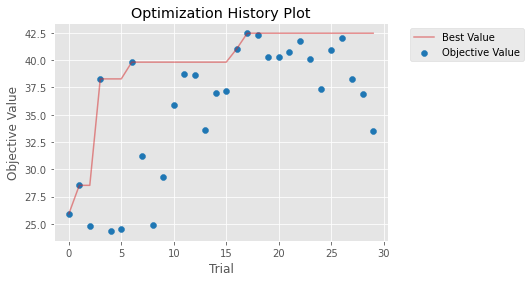

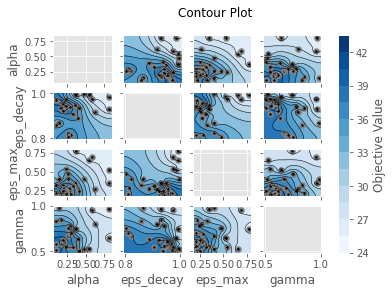

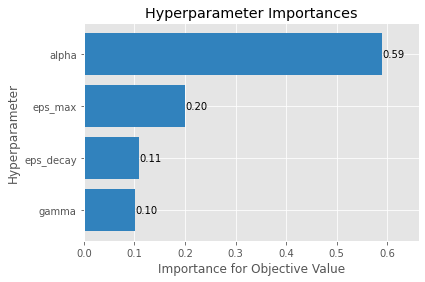

In [416]:
plt.figsize = (20, 10)
plot_optimization_history(study_ruql_augment)
plot_contour(study_ruql_augment)
plot_param_importances(study_ruql_augment)
plt.show()

##### Number of trials per customer required for policy testing

No handles with labels found to put in legend.


1420


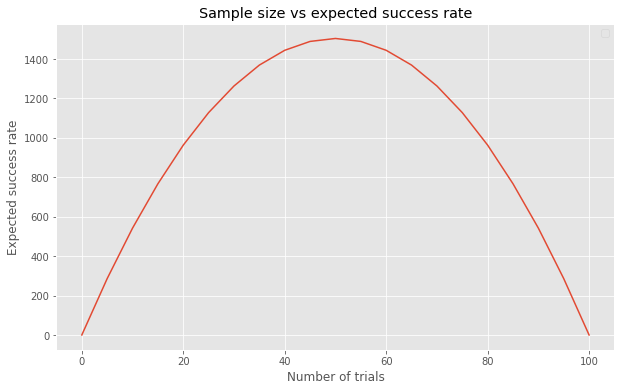

1504


In [289]:
import scipy.stats as stats
import math

def calculate_sample_size(expected_success_rate, margin_of_error, confidence_level):
    # Convert margin of error to decimal form
    margin_of_error = margin_of_error / 100.0

    # Calculate Z-score based on the confidence level
    z = stats.norm.ppf(1 - (1 - confidence_level) / 2)

    # Calculate the required sample size (number of trials)
    sample_size = (z**2 * expected_success_rate * (1 - expected_success_rate)) / margin_of_error**2

    # Round up to the nearest whole number
    sample_size = math.ceil(sample_size)

    return sample_size

print(calculate_sample_size(expected_success_rate=np.mean(exp_ql_standard.response_rate[10:])/100.0, margin_of_error=3, confidence_level=0.98))
sr = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
t = []
for i in range(len(sr)):
    t.append(calculate_sample_size(expected_success_rate=sr[i]/100.0, margin_of_error=3, confidence_level=0.98))
    
# Create a new figure instance
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data and customize the appearance
ax.set_xlabel("Number of trials")
ax.set_ylabel("Expected success rate")
ax.plot(sr, t)

# Add a legend
ax.legend()
ax.set_title("Sample size vs expected success rate")

# Show the plot
plt.show()

print(calculate_sample_size(50/100.0, margin_of_error=3, confidence_level=0.98))

### Test morning mailer policy

testing morning mailer...


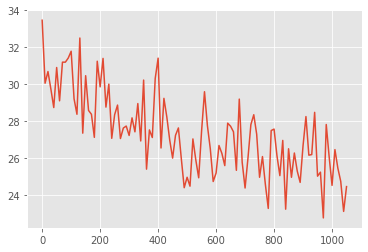

Customers left: 797


In [417]:
import matplotlib.pyplot as plt

NUMDAYS = 1054
customers = [cust for cust in gmm.sample(1000)[0]]
env = CustomerBaseFinalForm(customers, 1000, -100, ctp=1, unsub_freq=14)

avg_rate_morning = []

print("testing morning mailer...")

for i in range(NUMDAYS):
    todays_rate = 0
    state = env.reset()
    done = False
    total_steps = 0
    while not done:
        total_steps = total_steps + 1
        state, reward, done, opt_out = env.step(state, random.randint(8,11), i)
        if reward > 0 and env.opt_out[state] == 0:
            todays_rate += 1
    if i % 10 == 0:
        avg_rate_morning.append(todays_rate/(1000 - np.sum(env.opt_out)))
    # print(np.mean(np.mean(env.customer_response_functions, axis=0)))

avg_rate_morning = np.array(avg_rate_morning)*100
plt.figsize = (12, 6)
# plt.xlabel("Number of Episodes")
# plt.ylabel("Average Open Rate (%)")
plt.plot(np.arange(0, NUMDAYS, 10), avg_rate_morning)
plt.show()
print("Customers left:", 1000 - np.sum(env.opt_out))

### Testing a random policy

testing random policy...


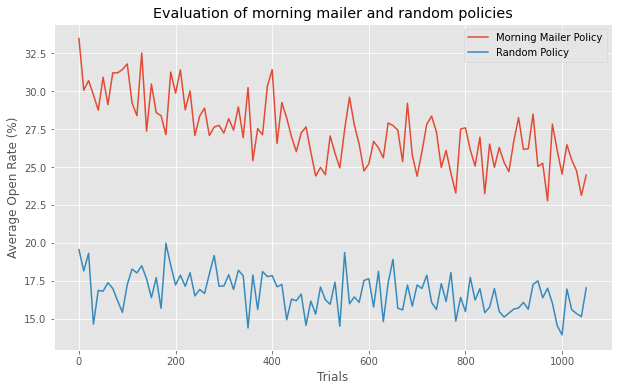

27.36552853368027
16.74144138607656


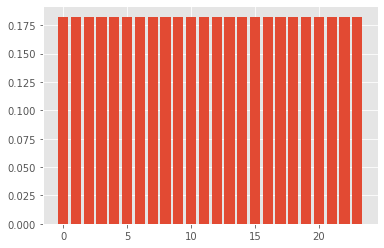

In [418]:
customers = [cust for cust in gmm.sample(1000)[0]]
env = CustomerBaseFinalForm(customers, 1000, -100, ctp=1, unsub_freq=14)

avg_rate_random = []
x = np.arange(0, NUMDAYS, 10)

print("testing random policy...")

for i in range(NUMDAYS):
    todays_rate = 0
    state = env.reset()
    done = False
    total_steps = 0
    while not done:
        total_steps = total_steps + 1
        state, reward, done, opt_out = env.step(state, random.randint(0,24), i)
        if reward > 0 and env.opt_out[state] == 0:
            todays_rate += 1
    if i % 10 == 0:
        avg_rate_random.append(todays_rate/(1000 - np.sum(env.opt_out)))

avg_rate_random = np.array(avg_rate_random)*100
plt.figsize = (12, 6)
# plt.xlabel("Number of Episodes")
# plt.ylabel("Average Open Rate (%)")
# plt.plot(np.arange(0, NUMDAYS, 10), avg_rate_random)
# plt.plot(np.arange(0, NUMDAYS, 10), avg_rate_morning)
# plt.legend(["Random Policy", "Morning Mailer"])
# plt.show()
# print("Customers left:", 1000 - np.sum(env.opt_out))

# Create a new figure instance
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data and customize the appearance
ax.set_xlabel("Trials")
ax.set_ylabel("Average Open Rate (%)")
ax.plot(x, avg_rate_morning, label='Morning Mailer Policy')
ax.plot(x, avg_rate_random, label='Random Policy')

# Add a legend
ax.legend()
ax.set_title("Evaluation of morning mailer and random policies")

# Show the plot
plt.show()

print(np.mean(avg_rate_morning))
print(np.mean(avg_rate_random))

plt.bar(range(0,24), np.mean(customers))
plt.show()



## Training Procedure

#### 1.Standard QL

In [383]:
# EXPERIMENT
# Note that this `env` is only instantiated to inform the agent about dimensions. The environment that is being simulated is contained within the Experiment class.

env = CustomerBaseFinalForm(customers, 1000, -100, ctp=0.001)

agent_ql_standard = QLearningAgentForFullCustomerBaseWithOpting(env,
                                 eps_start=1.0,
                                 eps_decay=study_ql_standard.best_params['eps_decay'],
                                 alpha=study_ql_standard.best_params['alpha'],
                                 gamma=study_ql_standard.best_params['gamma'])
agent_ql_standard_i = QLearningAgentForFullCustomerBaseWithOpting(env,
                                 eps_start=1.0,
                                 eps_decay=study_ql_standard.best_params['eps_decay'],
                                 alpha=study_ql_standard.best_params['alpha'],
                                 gamma=study_ql_standard.best_params['gamma'])

exp_ql_standard = Experiment(agent_ql_standard, customers, NUMDAYS, False, False, ctp=1, epsilon_tracking=False)
exp_ql_standard_i = Experiment(agent_ql_standard_i, customers, NUMDAYS, True, False, ctp=1, epsilon_tracking=False)
exp_ql_standard.train()
exp_ql_standard_i.train()

Training agent...


/Users/abrigrobler/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abrigrobler/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Customers left: 816
Training agent...
Customers left: 805


Average response rate over time


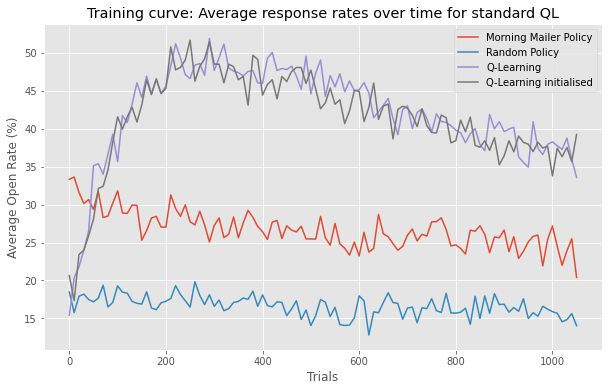

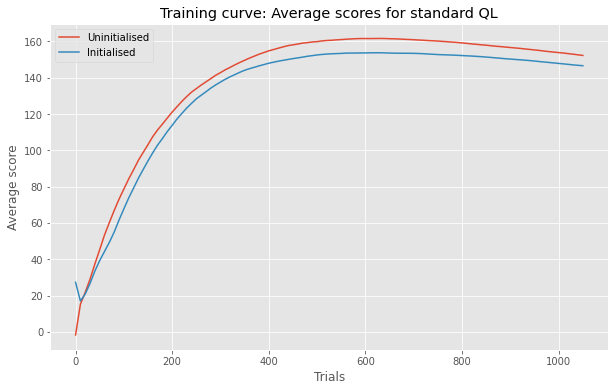

Average response rate over time 42.11834927997441


In [390]:
print("Average response rate over time")

# Create a new figure instance
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data and customize the appearance
ax.set_xlabel("Trials")
ax.set_ylabel("Average Open Rate (%)")
ax.plot(x, avg_rate_morning, label='Morning Mailer Policy')
ax.plot(x, avg_rate_random, label='Random Policy')
ax.plot(x, exp_ql_standard.response_rate, label="Q-Learning")
ax.plot(x, exp_ql_standard_i.response_rate, label="Q-Learning initialised")

# Add a legend
ax.legend()
ax.set_title("Training curve: Average response rates over time for standard QL")

# Show the plot
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data and customize the appearance
ax.set_xlabel("Trials")
ax.set_ylabel("Average score")
ax.plot(x, exp_ql_standard.scores, label="Uninitialised")
ax.plot(x, exp_ql_standard_i.scores, label="Initialised")

ax.legend()

ax.set_title("Training curve: Average scores for standard QL")

# # Create the twin axis
# ax2 = ax.twinx()
# ax2.set_ylim(0, 1)  # Setting the y-axis limits for the secondary y-axis
# ax2.set_ylabel('Average epsilon')
# # Plot the new function on the secondary y-axis
# ax2.plot(x, exp_ql_standard_i.average_epsilon, label='Epsilon', color="purple" )
# ax2.legend(loc="upper right")
plt.show()

print("Average response rate over time", np.mean(exp_ql_standard.response_rate))

#### 2.QL with augmented exploration

In [385]:
# EXPERIMENT
env = CustomerBaseFinalForm(customers, 1000, -100, ctp=1)

agent_ql_augment = QLA_EPSILON_TRACKING(env,
                             eps_start=1.0,
                             eps_decay=study_ql_aug.best_params['eps_decay'],
                             alpha=study_ql_aug.best_params['alpha'],
                             gamma=study_ql_aug.best_params['gamma'], eps_max=study_ql_aug.best_params['eps_max'])

agent_ql_augment_i = QLA_EPSILON_TRACKING(env,
                             eps_start=1.0,
                             eps_decay=study_ql_aug.best_params['eps_decay'],
                             alpha=study_ql_aug.best_params['alpha'],
                             gamma=study_ql_aug.best_params['gamma'], eps_max=study_ql_aug.best_params['eps_max'])

exp_ql_augment = Experiment(agent_ql_augment,
                 customers,
                 NUMDAYS,
                 False,
                 False,
                 ctp=1, epsilon_tracking=True)

exp_ql_augment_i = Experiment(agent_ql_augment_i,
                 customers,
                 NUMDAYS,
                 True,
                 False,
                 ctp=1, epsilon_tracking=True)
exp_ql_augment.train()
exp_ql_augment_i.train()

print("Average response rate over time")



Training agent...
Customers left: 816
Training agent...
Customers left: 804
Average response rate over time


Average response rate over time


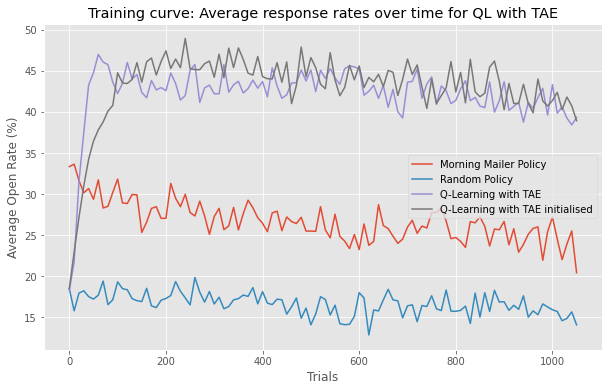

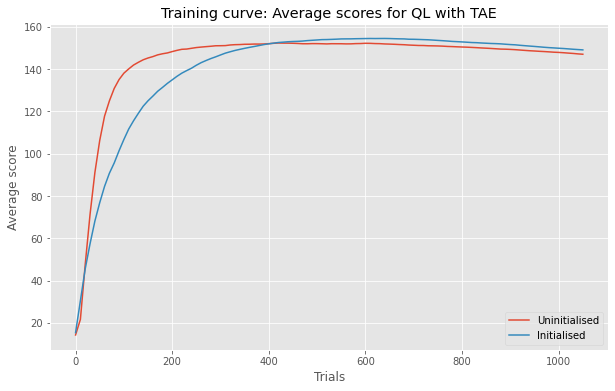

Average response rate over time 42.22253864920604


In [391]:
print("Average response rate over time")

# Create a new figure instance
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data and customize the appearance
ax.set_xlabel("Trials")
ax.set_ylabel("Average Open Rate (%)")
ax.plot(x, avg_rate_morning, label='Morning Mailer Policy')
ax.plot(x, avg_rate_random, label='Random Policy')
ax.plot(x, exp_ql_augment.response_rate, label="Q-Learning with TAE")
ax.plot(x, exp_ql_augment_i.response_rate, label="Q-Learning with TAE initialised")

# Add a legend
ax.legend()
ax.set_title("Training curve: Average response rates over time for QL with TAE")

# Show the plot
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data and customize the appearance
ax.set_xlabel("Trials")
ax.set_ylabel("Average score")
ax.plot(x, exp_ql_augment.scores, label="Uninitialised")
ax.plot(x, exp_ql_augment_i.scores, label="Initialised")
ax.legend()

ax.set_title("Training curve: Average scores for QL with TAE")

# Create the twin axis
# ax2 = ax.twinx()
# ax2.set_ylim(0, 1)  # Setting the y-axis limits for the secondary y-axis
# ax2.set_ylabel('Average epsilon')
# # Plot the new function on the secondary y-axis
# ax2.plot(x, exp_ql_augment_i.average_epsilon, label='Epsilon', color="purple" )
# ax2.plot(x, exp_ql_standard_i.average_epsilon, label='Epsilon', color="green" )
# ax2.legend(loc="upper right")

# Set the title
ax.set_title("Training curve: Average scores for QL with TAE")

# Display the plot
plt.show()



print("Average response rate over time", np.mean(exp_ql_augment.response_rate))

#### 3.RUQL with standard exploration


In [408]:
# EXPERIMENT
env = CustomerBaseFinalForm(customers, 1000, -100, ctp=0.001)

agent_ruql_standard = RUQLA(env, eps_start=1.0, 
                            eps_decay=study_ruql_standard.best_params['eps_decay'],
                            alpha=study_ruql_standard.best_params['alpha'],
                            gamma=study_ruql_standard.best_params['gamma'])

agent_ruql_standard_i = RUQLA(env, eps_start=1.0, 
                            eps_decay=study_ruql_standard.best_params['eps_decay'],
                            alpha=study_ruql_standard.best_params['alpha'],
                            gamma=study_ruql_standard.best_params['gamma'])
                            

exp_ruql_standard = Experiment(agent_ruql_standard,
                 customers,
                 NUMDAYS,
                 False,
                 False,
                 ctp=1,
                 epsilon_tracking=False)

exp_ruql_standard_i = Experiment(agent_ruql_standard_i,
                 customers,
                 NUMDAYS,
                 True,
                 False,
                 ctp=1,
                 epsilon_tracking=False)

exp_ruql_standard.train()
exp_ruql_standard_i.train()



Training agent...


/Users/abrigrobler/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abrigrobler/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Customers left: 794
Training agent...
Customers left: 826


Average response rate over time


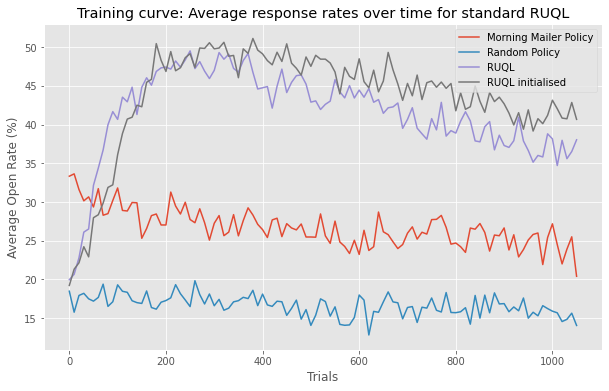

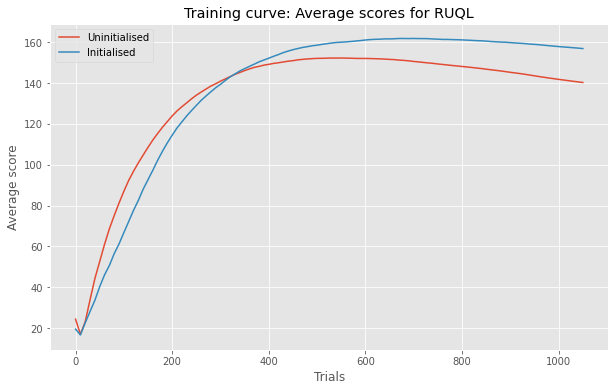

Average response rate over time 41.49724373059288


In [410]:
print("Average response rate over time")

# Create a new figure instance
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data and customize the appearance
ax.set_xlabel("Trials")
ax.set_ylabel("Average Open Rate (%)")
ax.plot(x, avg_rate_morning, label='Morning Mailer Policy')
ax.plot(x, avg_rate_random, label='Random Policy')
ax.plot(x, exp_ruql_standard.response_rate, label="RUQL")
ax.plot(x, exp_ruql_standard_i.response_rate, label="RUQL initialised")

# Add a legend
ax.legend()
ax.set_title("Training curve: Average response rates over time for standard RUQL")

# Show the plot
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data and customize the appearance
ax.set_xlabel("Trials")
ax.set_ylabel("Average score")
ax.plot(x, exp_ruql_standard.scores, label="Uninitialised")
ax.plot(x, exp_ruql_standard_i.scores, label="Initialised")
ax.legend()

ax.set_title("Training curve: Average scores for RUQL")

# Show the plot
plt.show()

print("Average response rate over time", np.mean(exp_ruql_standard.response_rate))

#### 4.RUQL with augmented exploration

In [419]:
# EXPERIMENT
env = CustomerBaseFinalForm(customers, 1000, -100, ctp=0.001)

agent = RUQLA_EPSILON_TRACKING(env,
                             eps_start=1.0,
                             eps_decay=study_ruql_augment.best_params['eps_decay'],
                             alpha=study_ruql_augment.best_params['alpha'],
                             gamma=study_ruql_augment.best_params['gamma'], eps_max=study_ruql_augment.best_params['eps_max'])

agent_i = RUQLA_EPSILON_TRACKING(env,
                             eps_start=1.0,
                             eps_decay=study_ruql_augment.best_params['eps_decay'],
                             alpha=study_ruql_augment.best_params['alpha'],
                             gamma=study_ruql_augment.best_params['gamma'], eps_max=study_ruql_augment.best_params['eps_max'])

exp_ruql_aug = Experiment(agent,
                 customers,
                 NUMDAYS,
                 False,
                 False,
                 ctp=1, epsilon_tracking=True)
exp_ruql_aug_i = Experiment(agent_i,
                 customers,
                 NUMDAYS,
                 True,
                 False,
                 ctp=1, epsilon_tracking=True)
exp_ruql_aug.train()
exp_ruql_aug_i.train()



Training agent...
Customers left: 807
Training agent...
Customers left: 789


Average response rate over time


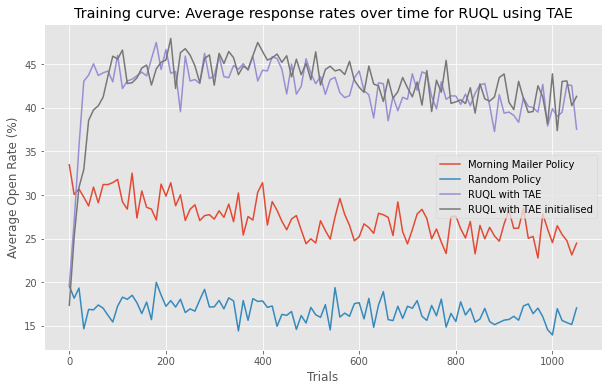

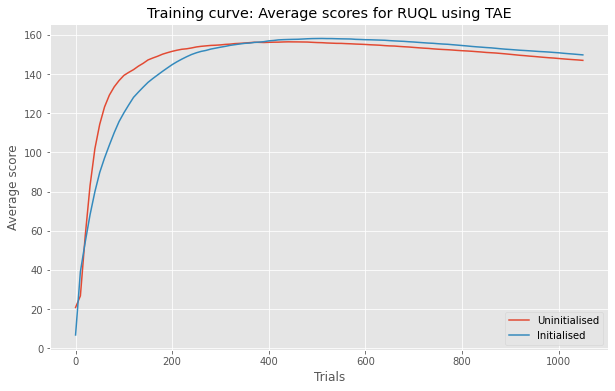

Average response rate over time 42.137268970655605


In [420]:
print("Average response rate over time")

# Create a new figure instance
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data and customize the appearance
ax.set_xlabel("Trials")
ax.set_ylabel("Average Open Rate (%)")
ax.plot(x, avg_rate_morning, label='Morning Mailer Policy')
ax.plot(x, avg_rate_random, label='Random Policy')
ax.plot(x, exp_ruql_aug.response_rate, label="RUQL with TAE")
ax.plot(x, exp_ruql_aug_i.response_rate, label="RUQL with TAE initialised")

# Add a legend
ax.legend()
ax.set_title("Training curve: Average response rates over time for RUQL using TAE")

# Show the plot
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data and customize the appearance
ax.set_xlabel("Trials")
ax.set_ylabel("Average score")
ax.plot(x, exp_ruql_aug.scores, label="Uninitialised")
ax.plot(x, exp_ruql_aug_i.scores, label="Initialised")
ax.legend()

ax.set_title("Training curve: Average scores for RUQL using TAE")

# Show the plot
plt.show()

print("Average response rate over time", np.mean(exp_ruql_aug.response_rate))

#### TAE vs Standard $\epsilon$-greedy

Now we plot the average reward (only for uninitialised agents, given that we don't see the biggest difference in performance between the two options), as well as the *average* value for $\epsilon$ for TAE agents, or the exact value for non-TAE agents. This is to investigate the drop in performance in the non-TAE agents, and whether or not this actually stems from using TAE.

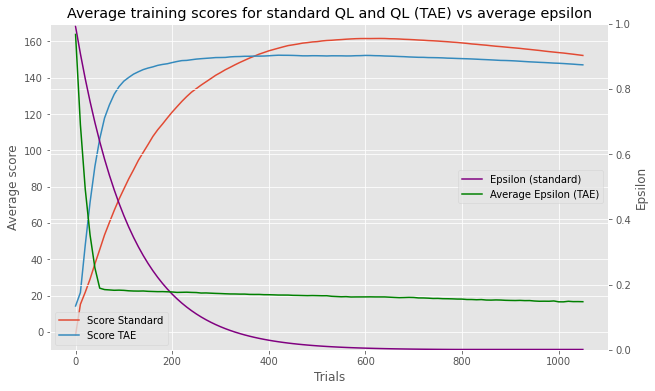

In [421]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data and customize the appearance
ax.set_xlabel("Trials")
ax.set_ylabel("Average score")
ax.plot(x, exp_ql_standard.scores, label="Score Standard")
ax.plot(x, exp_ql_augment.scores, label="Score TAE")
ax.legend(loc="lower left")


ax2 = ax.twinx()
ax2.set_ylim(0, 1)  # Setting the y-axis limits for the secondary y-axis
ax2.set_ylabel('Epsilon')
# Plot the new function on the secondary y-axis
ax2.plot(x, exp_ql_standard.average_epsilon, label='Epsilon (standard)', color="purple" )
ax2.plot(x, exp_ql_augment.average_epsilon, label='Average Epsilon (TAE)', color="green" )
ax2.legend(loc="center right")

# Set the title
ax.set_title("Average training scores for standard QL and QL (TAE) vs average epsilon")

# Display the plot
plt.show()

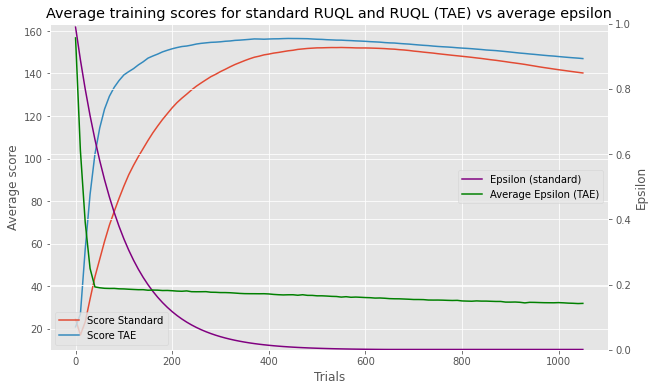

In [422]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data and customize the appearance
ax.set_xlabel("Trials")
ax.set_ylabel("Average score")
ax.plot(x, exp_ruql_standard.scores, label="Score Standard")
ax.plot(x, exp_ruql_aug.scores, label="Score TAE")
ax.legend(loc="lower left")


ax2 = ax.twinx()
ax2.set_ylim(0, 1)  # Setting the y-axis limits for the secondary y-axis
ax2.set_ylabel('Epsilon')
# Plot the new function on the secondary y-axis
ax2.plot(x, exp_ruql_standard.average_epsilon, label='Epsilon (standard)', color="purple" )
ax2.plot(x, exp_ruql_aug.average_epsilon, label='Average Epsilon (TAE)', color="green" )
ax2.legend(loc="center right")

# Set the title
ax.set_title("Average training scores for standard RUQL and RUQL (TAE) vs average epsilon")

# Display the plot
plt.show()

## Policy Evaluation on a static environment

### Evaluate random and morning policies on static environment

testing morning mailer...
testing random policy...


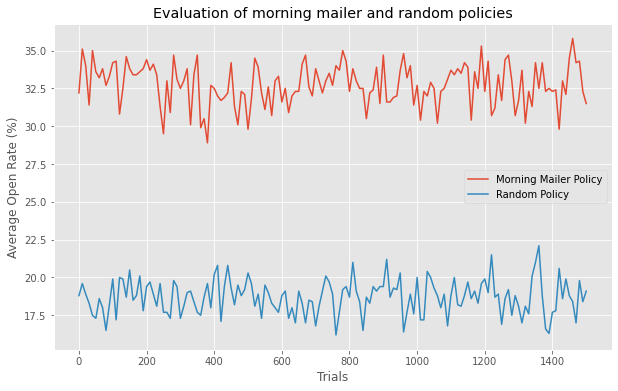

32.72781456953643
18.706622516556294


In [423]:

NUMDAYS = 1504
customers = [cust for cust in gmm.sample(1000)[0]]
env = CustomerBaseFinalForm(customers, 500, -100, ctp=0, unsub_freq=14)
env.prob_inactive = 0
env.opt_out_prob = 0

avg_rate_morning = []

print("testing morning mailer...")

for i in range(NUMDAYS):
    todays_rate = 0
    state = env.reset()
    done = False
    total_steps = 0
    while not done:
        total_steps = total_steps + 1
        state, reward, done, opt_out = env.step(state, random.randint(8,11), i)
        if reward > 0 and env.opt_out[state] == 0:
            todays_rate += 1
    if i % 10 == 0:
        avg_rate_morning.append(todays_rate/(1000 - np.sum(env.opt_out)))

avg_rate_morning = np.array(avg_rate_morning)*100





customers = [cust for cust in gmm.sample(1000)[0]]


env = CustomerBaseFinalForm(customers, 500, -100, ctp=0, unsub_freq=14)
env.prob_inactive = 0
env.opt_out_prob = 0

avg_rate_random = []
x = np.arange(0, NUMDAYS, 10)

print("testing random policy...")

for i in range(NUMDAYS):
    todays_rate = 0
    state = env.reset()
    done = False
    total_steps = 0
    while not done:
        total_steps = total_steps + 1
        state, reward, done, opt_out = env.step(state, random.randint(0,24), i)
        if reward > 0 and env.opt_out[state] == 0:
            todays_rate += 1
    if i % 10 == 0:
        avg_rate_random.append(todays_rate/(1000 - np.sum(env.opt_out)))

avg_rate_random = np.array(avg_rate_random)*100


# Create a new figure instance
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data and customize the appearance
ax.set_xlabel("Trials")
ax.set_ylabel("Average Open Rate (%)")
ax.plot(x, avg_rate_morning, label='Morning Mailer Policy')
ax.plot(x, avg_rate_random, label='Random Policy')

# Add a legend
ax.legend()
ax.set_title("Evaluation of morning mailer and random policies")

# Show the plot
plt.show()

print(np.mean(avg_rate_morning))
print(np.mean(avg_rate_random))

In [424]:
NUM_TRIALS = [1504, 1504, 1504, 1504]
r_0 = exp_ql_standard.test(trials=NUM_TRIALS[0])
r_0_i = exp_ql_standard_i.test(trials=NUM_TRIALS[0])
r_1 = exp_ql_augment.test(NUM_TRIALS[1])
r_1_i = exp_ql_augment_i.test(NUM_TRIALS[1])
r_2 = exp_ruql_standard.test(NUM_TRIALS[2])
r_2_i = exp_ruql_standard_i.test(NUM_TRIALS[2])
r_3 = exp_ruql_aug.test(NUM_TRIALS[3])
r_3_i = exp_ruql_aug_i.test(NUM_TRIALS[3])

Testing policy...


/Users/abrigrobler/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abrigrobler/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Testing policy...
Testing policy...
Testing policy...
Testing policy...
Testing policy...
Testing policy...
Testing policy...


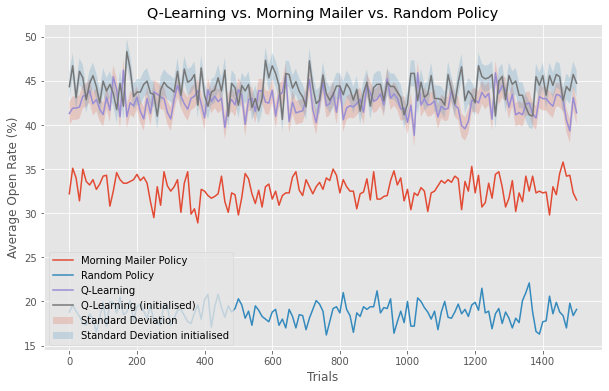

Mean: 42.51975935131733
Error: 1.27559278053952
Increase: 8.516352001241387

Standard Deviation: 1.3360178638292812
Mean + 3 percent error: 43.79535213185685
Mean - 3 percent error: 41.244166570777814

Mean (initialised): 44.10711302911414
Error: 1.323213390873424
Increase: 10.056085068704284

Standard Deviation (initialised): 1.4800598401423026
Mean + 3 percent error: 45.430326419987566
Mean - 3 percent error: 42.78389963824071
Relative improvement 34.76950297246472


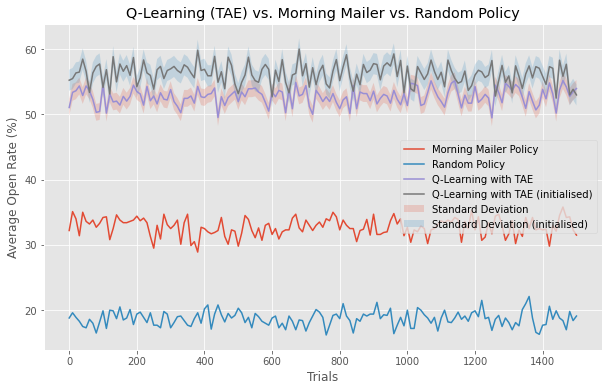

Mean: 52.715976822266995
Error: 1.5814793046680098
Increase: 18.40668294806256

Standard Deviation: 1.2881515114346977
Mean + 3 percent error: 54.297456126935
Mean - 3 percent error: 51.13449751759899

Mean: 56.159450458226935
Error: 1.684783513746808
Increase: 21.7468523749437

Standard Deviation: 1.6192898012341885
Mean + 3 percent error: 57.84423397197374
Mean - 3 percent error: 54.47466694448013
Relative improvement 71.5954798598164


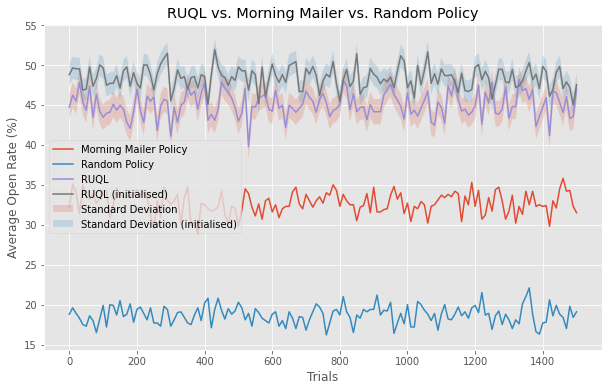

Mean: 45.020157281478525
Error: 1.3506047184443557
Increase: 10.941737993497739

Standard Deviation: 1.5824912002674352
Mean + 3 percent error: 46.370761999922884
Mean - 3 percent error: 43.669552563034166

Mean: 48.39285973070821
Error: 1.4517857919212462
Increase: 14.213259369250537

Standard Deviation: 1.3811972551446805
Mean + 3 percent error: 49.844645522629456
Mean - 3 percent error: 46.941073938786964
Relative improvement 47.86462330959629


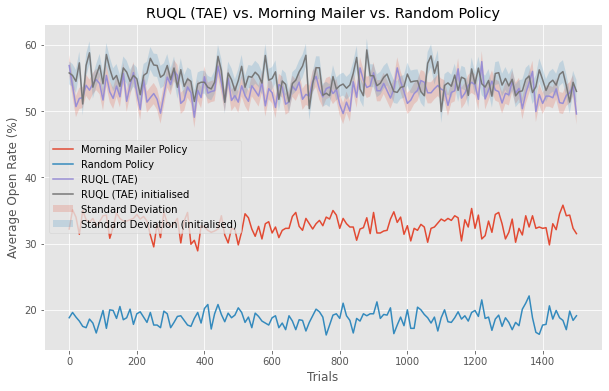

Mean: 53.018167244934155
Error: 1.5905450173480247
Increase: 18.6998076580497

Standard Deviation: 1.596809996855387
Mean + 3 percent error: 54.60871226228218
Mean - 3 percent error: 51.42762222758613

Mean: 54.70982743118988
Error: 1.6412948229356963
Increase: 20.340718038717753

Standard Deviation: 1.7255236339814197
Mean + 3 percent error: 56.35112225412558
Mean - 3 percent error: 53.06853260825418
Relative improvement 67.16614949937617


In [428]:
r_0 = exp_ql_standard.results
r_0_i = exp_ql_standard_i.results
r_1 = exp_ql_augment.results
r_1_i = exp_ql_augment_i.results
r_2 = exp_ruql_standard.results
r_2_i = exp_ruql_standard_i.results
r_3 = exp_ruql_aug.results
r_3_i = exp_ruql_aug_i.results

x = np.arange(0, NUMDAYS, 10)

# STANDARD QL
std_dev_ql_std = np.std(r_0['response_rate'])
std_dev_ql_std_i = np.std(r_0_i['response_rate'])

# Create a new figure instance
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data and customize the appearance
ax.set_xlabel("Trials")
ax.set_ylabel("Average Open Rate (%)")
ax.plot(x, avg_rate_morning, label='Morning Mailer Policy')
ax.plot(x, avg_rate_random, label='Random Policy')
ax.plot(np.arange(0, NUM_TRIALS[0], 10), r_0['response_rate'], label='Q-Learning')
ax.fill_between(np.arange(0, NUM_TRIALS[0], 10), r_0['response_rate'] - std_dev_ql_std, r_0['response_rate'] + std_dev_ql_std, alpha=0.2, label='Standard Deviation')
ax.plot(np.arange(0, NUM_TRIALS[0], 10), r_0_i['response_rate'], label='Q-Learning (initialised)')
ax.fill_between(np.arange(0, NUM_TRIALS[0], 10), r_0_i['response_rate'] - std_dev_ql_std_i, r_0_i['response_rate'] + std_dev_ql_std_i, alpha=0.2, label='Standard Deviation initialised')

# Add a legend
ax.legend()
ax.set_title("Q-Learning vs. Morning Mailer vs. Random Policy")

# Show the plot
plt.show()

print("Mean:", np.mean(r_0['response_rate']))
print("Error:", np.mean(r_0['response_rate'])*0.03)
print("Increase:", np.mean(r_0['response_rate']) - np.mean(r_0['response_rate'])*0.03 - np.mean(avg_rate_morning))
print()
print("Standard Deviation:", std_dev_ql_std)
print("Mean + 3 percent error:", np.mean(r_0['response_rate']) + np.mean(r_0['response_rate'])*0.03)
print("Mean - 3 percent error:", np.mean(r_0['response_rate']) - np.mean(r_0['response_rate'])*0.03)
print()
print("Mean (initialised):", np.mean(r_0_i['response_rate']))
print("Error:", np.mean(r_0_i['response_rate'])*0.03)
print("Increase:", np.mean(r_0_i['response_rate']) - np.mean(r_0_i['response_rate'])*0.03 - np.mean(avg_rate_morning))
print()
print("Standard Deviation (initialised):", std_dev_ql_std_i)
print("Mean + 3 percent error:", np.mean(r_0_i['response_rate']) + np.mean(r_0_i['response_rate'])*0.03)
print("Mean - 3 percent error:", np.mean(r_0_i['response_rate']) - np.mean(r_0_i['response_rate'])*0.03)

print("Relative improvement", (np.mean(r_0_i['response_rate']) - np.mean(avg_rate_morning))/np.mean(avg_rate_morning)*100)

# AUGMENTED QL

std_dev_ql_aug = np.std(r_1['response_rate'])
std_dev_ql_aug_i = np.std(r_1_i['response_rate'])

# Create a new figure instance
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data and customize the appearance
ax.set_xlabel("Trials")
ax.set_ylabel("Average Open Rate (%)")
ax.plot(x, avg_rate_morning, label='Morning Mailer Policy')
ax.plot(x, avg_rate_random, label='Random Policy')
ax.plot(np.arange(0, NUM_TRIALS[1], 10), r_1['response_rate'], label='Q-Learning with TAE')
ax.fill_between(np.arange(0, NUM_TRIALS[1], 10), r_1['response_rate'] - std_dev_ql_aug, r_1['response_rate'] + std_dev_ql_aug, alpha=0.2, label='Standard Deviation')
ax.plot(np.arange(0, NUM_TRIALS[1], 10), r_1_i['response_rate'], label='Q-Learning with TAE (initialised)')
ax.fill_between(np.arange(0, NUM_TRIALS[1], 10), r_1_i['response_rate'] - std_dev_ql_aug_i, r_1_i['response_rate'] + std_dev_ql_aug_i, alpha=0.2, label='Standard Deviation (initialised)')

# Add a legend
ax.legend()
ax.set_title("Q-Learning (TAE) vs. Morning Mailer vs. Random Policy")

# Show the plot
plt.show()

print("Mean:", np.mean(r_1['response_rate']))
print("Error:", np.mean(r_1['response_rate'])*0.03)
print("Increase:", np.mean(r_1['response_rate']) - np.mean(r_1['response_rate'])*0.03 - np.mean(avg_rate_morning))
print()
print("Standard Deviation:", std_dev_ql_aug)
print("Mean + 3 percent error:", np.mean(r_1['response_rate']) + np.mean(r_1['response_rate'])*0.03)
print("Mean - 3 percent error:", np.mean(r_1['response_rate']) - np.mean(r_1['response_rate'])*0.03)
print()
print("Mean:", np.mean(r_1_i['response_rate']))
print("Error:", np.mean(r_1_i['response_rate'])*0.03)
print("Increase:", np.mean(r_1_i['response_rate']) - np.mean(r_1_i['response_rate'])*0.03 - np.mean(avg_rate_morning))
print()
print("Standard Deviation:", std_dev_ql_aug_i)
print("Mean + 3 percent error:", np.mean(r_1_i['response_rate']) + np.mean(r_1_i['response_rate'])*0.03)
print("Mean - 3 percent error:", np.mean(r_1_i['response_rate']) - np.mean(r_1_i['response_rate'])*0.03)

print("Relative improvement", (np.mean(r_1_i['response_rate']) - np.mean(avg_rate_morning))/np.mean(avg_rate_morning)*100)

# STANDARD RUQL

std_dev_ruql_std = np.std(r_2['response_rate'])
std_dev_ruql_std_i = np.std(r_2_i['response_rate'])

# Create a new figure instance
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data and customize the appearance
ax.set_xlabel("Trials")
ax.set_ylabel("Average Open Rate (%)")
ax.plot(x, avg_rate_morning, label='Morning Mailer Policy')
ax.plot(x, avg_rate_random, label='Random Policy')
ax.plot(np.arange(0, NUM_TRIALS[2], 10), r_2['response_rate'], label='RUQL')
ax.fill_between(np.arange(0, NUM_TRIALS[2], 10), r_2['response_rate'] - std_dev_ruql_std, r_2['response_rate'] + std_dev_ruql_std, alpha=0.2, label='Standard Deviation')
ax.plot(np.arange(0, NUM_TRIALS[2], 10), r_2_i['response_rate'], label='RUQL (initialised)')
ax.fill_between(np.arange(0, NUM_TRIALS[2], 10), r_2_i['response_rate'] - std_dev_ruql_std_i, r_2_i['response_rate'] + std_dev_ruql_std_i, alpha=0.2, label='Standard Deviation (initialised)')

# Add a legend
ax.legend()
ax.set_title("RUQL vs. Morning Mailer vs. Random Policy")

# Show the plot
plt.show()

print("Mean:", np.mean(r_2['response_rate']))
print("Error:", np.mean(r_2['response_rate'])*0.03)
print("Increase:", np.mean(r_2['response_rate']) - np.mean(r_2['response_rate'])*0.03 - np.mean(avg_rate_morning))
print()
print("Standard Deviation:", std_dev_ruql_std)
print("Mean + 3 percent error:", np.mean(r_2['response_rate']) + np.mean(r_2['response_rate'])*0.03)
print("Mean - 3 percent error:", np.mean(r_2['response_rate']) - np.mean(r_2['response_rate'])*0.03)
print()
print("Mean:", np.mean(r_2_i['response_rate']))
print("Error:", np.mean(r_2_i['response_rate'])*0.03)
print("Increase:", np.mean(r_2_i['response_rate']) - np.mean(r_2_i['response_rate'])*0.03 - np.mean(avg_rate_morning))
print()
print("Standard Deviation:", std_dev_ruql_std_i)
print("Mean + 3 percent error:", np.mean(r_2_i['response_rate']) + np.mean(r_2_i['response_rate'])*0.03)
print("Mean - 3 percent error:", np.mean(r_2_i['response_rate']) - np.mean(r_2_i['response_rate'])*0.03)

print("Relative improvement", (np.mean(r_2_i['response_rate']) - np.mean(avg_rate_morning))/np.mean(avg_rate_morning)*100)

#AUGMENTED RUQL

std_dev_ruql_aug = np.std(r_3['response_rate'])
std_dev_ruql_aug_i = np.std(r_3_i['response_rate'])

# Create a new figure instance
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data and customize the appearance
ax.set_xlabel("Trials")
ax.set_ylabel("Average Open Rate (%)")
ax.plot(x, avg_rate_morning, label='Morning Mailer Policy')
ax.plot(x, avg_rate_random, label='Random Policy')
ax.plot(np.arange(0, NUM_TRIALS[3], 10), r_3['response_rate'], label='RUQL (TAE)')
ax.fill_between(np.arange(0, NUM_TRIALS[3], 10), r_3['response_rate'] - std_dev_ruql_aug, r_3['response_rate'] + std_dev_ruql_aug, alpha=0.2, label='Standard Deviation')
ax.plot(np.arange(0, NUM_TRIALS[3], 10), r_3_i['response_rate'], label='RUQL (TAE) initialised')
ax.fill_between(np.arange(0, NUM_TRIALS[3], 10), r_3_i['response_rate'] - std_dev_ruql_aug_i, r_3_i['response_rate'] + std_dev_ruql_aug_i, alpha=0.2, label='Standard Deviation (initialised)')

# Add a legend
ax.legend()
ax.set_title("RUQL (TAE) vs. Morning Mailer vs. Random Policy")

# Show the plot
plt.show()

print("Mean:", np.mean(r_3['response_rate']))
print("Error:", np.mean(r_3['response_rate'])*0.03)
print("Increase:", np.mean(r_3['response_rate']) - np.mean(r_3['response_rate'])*0.03 - np.mean(avg_rate_morning))
print()
print("Standard Deviation:", std_dev_ruql_aug)
print("Mean + 3 percent error:", np.mean(r_3['response_rate']) + np.mean(r_3['response_rate'])*0.03)
print("Mean - 3 percent error:", np.mean(r_3['response_rate']) - np.mean(r_3['response_rate'])*0.03)
print()
print("Mean:", np.mean(r_3_i['response_rate']))
print("Error:", np.mean(r_3_i['response_rate'])*0.03)
print("Increase:", np.mean(r_3_i['response_rate']) - np.mean(r_3_i['response_rate'])*0.03 - np.mean(avg_rate_morning))
print()
print("Standard Deviation:", std_dev_ruql_aug_i)
print("Mean + 3 percent error:", np.mean(r_3_i['response_rate']) + np.mean(r_3_i['response_rate'])*0.03)
print("Mean - 3 percent error:", np.mean(r_3_i['response_rate']) - np.mean(r_3_i['response_rate'])*0.03)

print("Relative improvement", (np.mean(r_3_i['response_rate']) - np.mean(avg_rate_morning))/np.mean(avg_rate_morning)*100)


## Deep-Q Networks

### DQN Agent 

In [203]:
plt.figsize = (10, 10)

class DQN_Utils:
    def _padarray(A, size):
        t = size - len(A)
        return np.pad(A, pad_width=(0, t), mode='constant')

    def encode_input(inpt):
        unpadded_binary = [int(x) for x in list('{0:0b}'.format(inpt))]
        return DQN_Utils._padarray(unpadded_binary, 11)

class DQN(nn.Module):
    # TODO: Add some more params to the constructor fcn
    def __init__(self, env, size):
        super().__init__()
        # Define input dimensions
        input_dims = 24
        # Set up the NN
        self.net = nn.Sequential(
            nn.Linear(input_dims, size),
            nn.ReLU(),
            nn.Linear(size, size), 
            nn.ReLU(),
            nn.Linear(size, env.n_actions))
        self.device = torch.device('cpu')
        self.net.to(self.device)

    def forward(self, x):
        return self.net(x)
        

    def act(self, obs, array=False):
        #print(obs)
        obs_t = torch.as_tensor(obs, dtype=torch.float32).to(self.device)
        #print(obs_t)
        q_values = self(obs_t.unsqueeze(0))

        if array:
            return q_values.detach().numpy()

        max_q_index = torch.argmax(q_values, dim=1)[0]
        action = max_q_index.detach().item()
        return action


class DQNAgent():
    def __init__(self, env, gamma=0.99, batch_size=32, buffer_size=1000,
                 min_replay_size=32, epsilon_start=1.0, epsilon_decay=0.9996, n_nodes=12, learning_rate=0.001, use_individual_epsilon=False):

        self.replay_buffer = deque(maxlen=buffer_size)
        self.alpha = 0.3

        self.rew_buffer = deque([0, 0], maxlen=100)
        self.epsilon = epsilon_start
        self.gamma, self.batch_size, self.min_replay_size, self.epsilon_decay = gamma, batch_size, min_replay_size, epsilon_decay

        self.online_net = DQN(env, n_nodes)
        self.target_net = DQN(env, n_nodes)
        
        self.epsilon_array = np.ones(env.n_states, dtype=float) * epsilon_start
        self.use_individual_epsilon = use_individual_epsilon

        self.optimizer = torch.optim.Adam(
            self.online_net.parameters(), lr=learning_rate)
        
        # This is to ensure that newtorks are identical at the start
        self.target_net.load_state_dict(self.online_net.state_dict())
        self.env = env
       
        # Creates internal knowledge of the customers
        self.customer_profiles = np.zeros((env.n_states, env.n_actions-1), dtype=float)
        for i in range(env.n_states):
            self.customer_profiles[i,0:24] = dist_synth
        self.init_replay_buffer()


# Initialise replay buffer

    def store_transition(self, transition):
        self.replay_buffer.append(transition)

    def init_replay_buffer(self):
        obs = self.env.reset()

        for _ in range(self.min_replay_size):
            action = np.random.choice(range(self.env.n_actions))
            new_obs, rew, done, _ = self.env.step(obs, action, _)
            transition = (self.customer_profiles[obs,:], action, rew, done,
                      self.customer_profiles[new_obs,:])
            self.replay_buffer.append(transition)
            obs = new_obs

            if done:
                obs = self.env.reset()
                
    def choose_action(self, state, obs=0):
        '''
        Returns an e-greedy action
        '''
        if self.use_individual_epsilon:
            epsilon = self.epsilon_array[obs]
        else:
            epsilon = self.epsilon
            
        if random.uniform(0, 1) < epsilon:
            # Explore
            action = np.random.choice(range(self.env.n_actions))
            return action
        else:
            # Exploit
            action = self.online_net.act(state)

            return action

    def update_customer_profiles(self, state, action, reward, state_, customer_opted_out):
        if action == 24 or customer_opted_out == 1:
            return

        error = self.gamma * np.max(self.customer_profiles[state_,:]) - self.customer_profiles[state,action]
        self.customer_profiles[state,action] = self.customer_profiles[state,action] + (reward + error)
        
        if self.use_individual_epsilon:
            if reward < 0 and self.epsilon_array[state] < 0.8:
                customer_eps = self.epsilon_array[state]
                self.epsilon_array[state] = np.minimum(customer_eps * 0.1 , 0.8)
            
        
        
        
    def decay_exploration(self, obs=0):
        if self.use_individual_epsilon:
            self.epsilon_array[obs] = max(self.epsilon_array[obs] * self.epsilon_decay, 0.01)
        else:
            self.epsilon = max(self.epsilon * self.epsilon_decay, 0.01)
        

    def learn(self):
        # Sample random transitions
        transitions = random.sample(self.replay_buffer, self.batch_size)

        observations = np.asarray([t[0] for t in transitions])
        actions = np.asarray([t[1] for t in transitions])
        rewards = np.asarray([t[2] for t in transitions])
        terminal = np.asarray([t[3] for t in transitions])
        new_observations = np.asarray([t[4] for t in transitions])
        

        observations_t = torch.as_tensor(
            observations, dtype=torch.float32).to(self.online_net.device)
        actions_t = torch.as_tensor(
            actions, dtype=torch.int64).unsqueeze(-1).to(self.online_net.device)
        rewards_t = torch.as_tensor(
            rewards, dtype=torch.float32).unsqueeze(-1).to(self.online_net.device)
        terminal_t = torch.as_tensor(
            terminal, dtype=torch.float32).unsqueeze(-1).to(self.online_net.device)
        new_observations_t = torch.as_tensor(
            new_observations, dtype=torch.float32).to(self.online_net.device)
        
        #print(observations_t)

        # Compute targets
        target_q_values = self.target_net.forward(new_observations_t)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]

        targets = rewards_t + self.gamma * (1-terminal_t) * max_target_q_values

        # Compute loss

        q_values = self.online_net(observations_t)
        action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

        loss = nn.functional.smooth_l1_loss(action_q_values, targets)

        # Gradient Descent

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()



### Experiment - DQN agent with single epsilon value

In [204]:
class DQNEXP:
    def __init__(self, gamma, n_nodes, epsilon_decay, learning_rate):
        self.NUM_CUSTOMERS = 1000
        self.customers = [cust for cust in gmm.sample(self.NUM_CUSTOMERS)[0]]
        self.env = CustomerBaseFinalForm(customers, 1000, -100, ctp=1)
        self.agent = DQNAgent(env,gamma=gamma, n_nodes=n_nodes, epsilon_decay=epsilon_decay, learning_rate=learning_rate)

        self.TARGET_UPDATE_FREQ = self.NUM_CUSTOMERS
        
    def train(self):
        obs = self.env.reset()
        scores = []
        avg_score = []
        response_rate = []
        total_steps = 0

        for i in range(1502):
            done = False
            episode_reward = 0
            responses = 0
            obs = self.env.reset()
            
            while not done:
                total_steps = total_steps + 1
                action = self.agent.choose_action(self.agent.customer_profiles[obs,:])
                new_obs, rew, done, opted_out = self.env.step(obs, action, i)

                transition = (self.agent.customer_profiles[obs,:], action, rew, done,
                            self.agent.customer_profiles[new_obs,:])
                
                if rew > 0:
                    responses = responses + 1

                self.agent.update_customer_profiles(obs, action, rew, new_obs, opted_out)
                self.agent.store_transition(transition)
                obs = new_obs
                self.agent.learn()
                episode_reward = episode_reward + rew


                if total_steps % self.TARGET_UPDATE_FREQ == 0:
                    self.agent.target_net.load_state_dict(self.agent.online_net.state_dict())

            self.agent.decay_exploration()
            self.agent.rew_buffer.append(episode_reward)
            scores.append(episode_reward)
            
            # Logging
            if i % 10 == 0:
                avg_score.append(np.mean(scores[-10:]))
                response_rate.append((responses * 100) / (self.NUM_CUSTOMERS - np.sum(self.env.opt_out == 1)))
                # print()
                # print('Episode', i + 10)
                # print('Average reward', np.mean(scores[-10:]), 'Epsilon',agent.epsilon)

        print("Done")
        return response_rate, avg_score
    
    def test(self):
        obs = self.env.reset()
        scores = []
        avg_score = []
        response_rate = []
        total_steps = 0
        self.env.ctp = 0
        self.env.prob_inactive = 0
        self.env.opt_out_prob = 0

        for i in range(1504):
            done = False
            episode_reward = 0
            responses = 0
            obs = self.env.reset()
            
            while not done:
                total_steps = total_steps + 1
                action = self.agent.choose_action(self.agent.customer_profiles[obs,:])
                new_obs, rew, done, _ = self.env.step(obs, action, i)
                
                if rew > 0:
                    responses = responses + 1
                obs = new_obs
                episode_reward = episode_reward + rew
            scores.append(episode_reward)
            
            # Logging
            if i % 10 == 0:
                avg_score.append(np.mean(scores[-10:]))
                response_rate.append((responses * 100) / (self.NUM_CUSTOMERS - np.sum(self.env.opt_out == 1)))
                # print()
                # print('Episode', i + 10)
                # print('Average reward', np.mean(scores[-10:]), 'Epsilon',agent.epsilon)

        print("Done")
        return response_rate, avg_score 

def DQNObjective(trial):
    # Define hyperparameter search space
    gamma = trial.suggest_float('gamma', 0.5, 0.99)
    epsilon_decay = trial.suggest_float('epsilon_decay', 0.999, 0.9999)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.01)
    n_nodes = trial.suggest_int('n_nodes', 12, 56)
    exp = DQNEXP(gamma, n_nodes, epsilon_decay, learning_rate)
    r, _ = exp.train()
    return np.mean(r)

# Create an Optuna study for maximizing the average episode reward
study_dqn = optuna.create_study(direction='maximize')
study_dqn.optimize(DQNObjective, n_trials=20) 

best_params_dqn = study_dqn.best_params
best_avg_open_rate = study_dqn.best_value

#Print the best parameters
print("Best Hyperparameters:", best_params_dqn)
print("Best Average Open Rate:", best_avg_open_rate)



[I 2023-10-20 07:05:01,598] A new study created in memory with name: no-name-0714a84e-a223-4da2-9579-b84d238568ea


[I 2023-10-20 07:34:41,481] Trial 0 finished with value: 15.58995432910184 and parameters: {'gamma': 0.6354064558463963, 'epsilon_decay': 0.999574381815629, 'learning_rate': 0.008095020438327532, 'n_nodes': 34}. Best is trial 0 with value: 15.58995432910184.


Done


[I 2023-10-20 08:08:32,263] Trial 1 finished with value: 16.165958971568482 and parameters: {'gamma': 0.7596261733484098, 'epsilon_decay': 0.9990908741513563, 'learning_rate': 0.003166945527250632, 'n_nodes': 56}. Best is trial 1 with value: 16.165958971568482.


Done


[I 2023-10-20 08:35:31,975] Trial 2 finished with value: 12.777105590854521 and parameters: {'gamma': 0.9226080251920181, 'epsilon_decay': 0.999418915647203, 'learning_rate': 0.009470547652670285, 'n_nodes': 22}. Best is trial 1 with value: 16.165958971568482.


Done


[I 2023-10-20 08:59:55,049] Trial 3 finished with value: 14.544964155067296 and parameters: {'gamma': 0.6712498543197444, 'epsilon_decay': 0.9996382546338336, 'learning_rate': 0.007730964218329922, 'n_nodes': 31}. Best is trial 1 with value: 16.165958971568482.


Done


[I 2023-10-20 09:24:19,458] Trial 4 finished with value: 17.320642204824786 and parameters: {'gamma': 0.7988035946429751, 'epsilon_decay': 0.99927040709513, 'learning_rate': 0.0028568175285353156, 'n_nodes': 25}. Best is trial 4 with value: 17.320642204824786.


Done


[I 2023-10-20 09:48:44,658] Trial 5 finished with value: 16.06077487538183 and parameters: {'gamma': 0.6903887445518179, 'epsilon_decay': 0.9991974303310768, 'learning_rate': 0.007139056794789566, 'n_nodes': 14}. Best is trial 4 with value: 17.320642204824786.


Done


[I 2023-10-20 10:12:56,057] Trial 6 finished with value: 11.269468521437302 and parameters: {'gamma': 0.8005978660753347, 'epsilon_decay': 0.9992488992723183, 'learning_rate': 0.008064244385987003, 'n_nodes': 23}. Best is trial 4 with value: 17.320642204824786.


Done


[I 2023-10-20 10:37:11,191] Trial 7 finished with value: 15.35204700224063 and parameters: {'gamma': 0.6362218633829154, 'epsilon_decay': 0.9997003501972447, 'learning_rate': 0.009055893002665745, 'n_nodes': 34}. Best is trial 4 with value: 17.320642204824786.


Done


[I 2023-10-20 11:01:26,998] Trial 8 finished with value: 24.548694239318394 and parameters: {'gamma': 0.9440458892538268, 'epsilon_decay': 0.9993903126921622, 'learning_rate': 0.0014915019854851148, 'n_nodes': 32}. Best is trial 8 with value: 24.548694239318394.


Done


[I 2023-10-20 11:25:55,348] Trial 9 finished with value: 15.485999371482094 and parameters: {'gamma': 0.5921749959231887, 'epsilon_decay': 0.9996939746493363, 'learning_rate': 0.008678521077766692, 'n_nodes': 41}. Best is trial 8 with value: 24.548694239318394.


Done


[I 2023-10-20 11:50:51,326] Trial 10 finished with value: 18.484101233516924 and parameters: {'gamma': 0.9870113697643217, 'epsilon_decay': 0.9998534473544286, 'learning_rate': 0.0020623897548419324, 'n_nodes': 46}. Best is trial 8 with value: 24.548694239318394.


Done


[I 2023-10-20 12:15:50,544] Trial 11 finished with value: 20.041663117053428 and parameters: {'gamma': 0.9875227967779336, 'epsilon_decay': 0.9998690471427162, 'learning_rate': 0.0010656533431140434, 'n_nodes': 46}. Best is trial 8 with value: 24.548694239318394.


Done


[I 2023-10-20 12:41:14,264] Trial 12 finished with value: 24.452784585090495 and parameters: {'gamma': 0.8995431756264165, 'epsilon_decay': 0.9994361759954071, 'learning_rate': 0.0010678466578748385, 'n_nodes': 46}. Best is trial 8 with value: 24.548694239318394.


Done


[I 2023-10-20 13:06:01,207] Trial 13 finished with value: 13.108411921201146 and parameters: {'gamma': 0.8944382945947713, 'epsilon_decay': 0.9994184804085678, 'learning_rate': 0.004541467475624401, 'n_nodes': 42}. Best is trial 8 with value: 24.548694239318394.


Done


[I 2023-10-20 13:31:42,727] Trial 14 finished with value: 24.650352372799265 and parameters: {'gamma': 0.8727516927755794, 'epsilon_decay': 0.9994886371119903, 'learning_rate': 0.001143138477116844, 'n_nodes': 56}. Best is trial 14 with value: 24.650352372799265.


Done


[I 2023-10-20 13:57:25,457] Trial 15 finished with value: 13.812764767722262 and parameters: {'gamma': 0.8345558384874232, 'epsilon_decay': 0.9995288534317315, 'learning_rate': 0.004160314294845029, 'n_nodes': 55}. Best is trial 14 with value: 24.650352372799265.


Done


[I 2023-10-20 14:21:34,541] Trial 16 finished with value: 12.125831034085317 and parameters: {'gamma': 0.8571019580825877, 'epsilon_decay': 0.9993434890990704, 'learning_rate': 0.0060850537892589845, 'n_nodes': 28}. Best is trial 14 with value: 24.650352372799265.


Done


[I 2023-10-20 14:46:44,722] Trial 17 finished with value: 22.42716767280593 and parameters: {'gamma': 0.5202880230028548, 'epsilon_decay': 0.9990144519460392, 'learning_rate': 0.002208871075160398, 'n_nodes': 39}. Best is trial 14 with value: 24.650352372799265.


Done


[I 2023-10-20 15:10:37,640] Trial 18 finished with value: 11.86344568924757 and parameters: {'gamma': 0.9328978428339936, 'epsilon_decay': 0.9993220973275935, 'learning_rate': 0.004037949998724988, 'n_nodes': 14}. Best is trial 14 with value: 24.650352372799265.


Done


[I 2023-10-20 15:36:22,373] Trial 19 finished with value: 13.892748230534721 and parameters: {'gamma': 0.8502318987339095, 'epsilon_decay': 0.999504553779898, 'learning_rate': 0.0053015958195410055, 'n_nodes': 53}. Best is trial 14 with value: 24.650352372799265.


Done
Best Hyperparameters: {'gamma': 0.8727516927755794, 'epsilon_decay': 0.9994886371119903, 'learning_rate': 0.001143138477116844, 'n_nodes': 56}
Best Average Open Rate: 24.650352372799265


<ipython-input-268-aa74115203f3>:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_dqn)
<ipython-input-268-aa74115203f3>:3: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study_dqn)
[W 2023-10-23 18:47:06,804] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
<ipython-input-268-aa74115203f3>:4: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study_dqn)


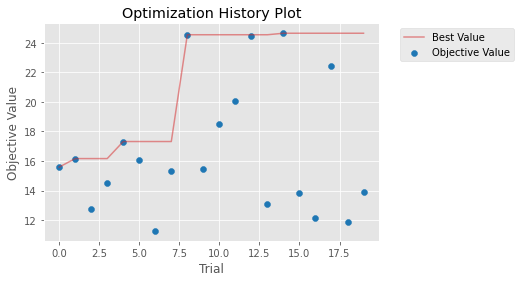

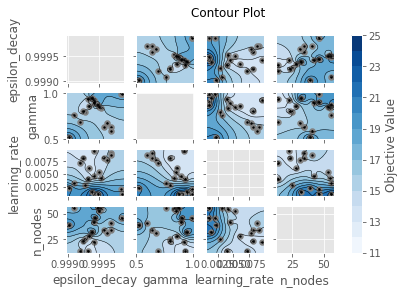

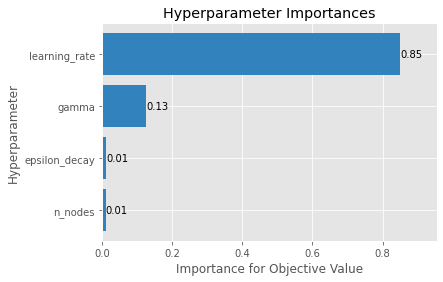

In [268]:
plt.figsize = (20, 10)
plot_optimization_history(study_dqn)
plot_contour(study_dqn)
plot_param_importances(study_dqn)
plt.show()

In [230]:
exp_dqn = DQNEXP(gamma=0.8727516927755794, n_nodes=56, epsilon_decay=0.9994886371119903, learning_rate=0.001143138477116844)
response_rate, avg_score = exp_dqn.train()


Done


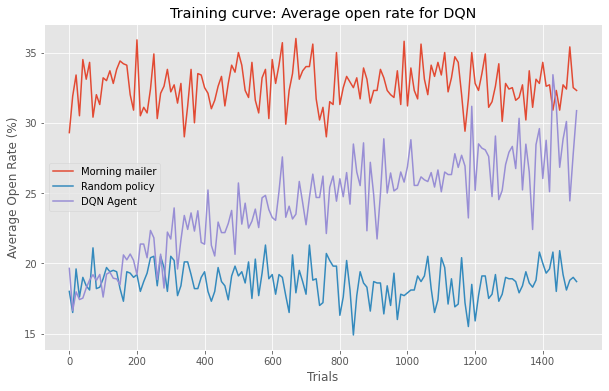

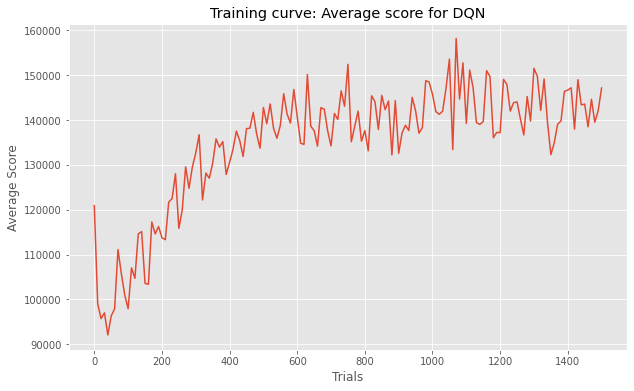

In [231]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data and customize the appearance
ax.set_xlabel("Trials")
ax.set_ylabel("Average Open Rate (%)")
ax.plot(np.arange(0, NUMDAYS, 10), avg_rate_morning)
ax.plot(np.arange(0, NUMDAYS, 10), avg_rate_random)
ax.plot(np.arange(0, len(response_rate)*10, 10), response_rate)
ax.set_title("Training curve: Average open rate for DQN")
ax.legend(['Morning mailer', 'Random policy', 'DQN Agent'])

# Show the plot
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data and customize the appearance
ax.set_xlabel("Trials")
ax.set_ylabel("Average Score")
ax.plot(np.arange(0, len(response_rate)*10, 10), avg_score)
ax.set_title("Training curve: Average score for DQN")

# Show the plot
plt.show()

In [232]:
response_rate, avg_score = exp_dqn.test()

Done


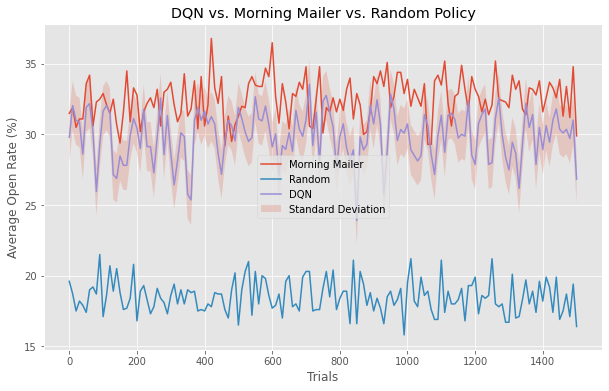

Mean: 29.886161524413893
Standard Deviation: 1.747386777776809
Mean + 3 percent error: 30.78274637014631
Mean - 3 percent error: 28.989576678681477
Relative improvement -8.095016797619348


In [267]:
std_dev_ruql_aug = np.std(response_rate)

# Create a new figure instance
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data and customize the appearance
ax.set_xlabel("Trials")
ax.set_ylabel("Average Open Rate (%)")
ax.plot(np.arange(0, NUMDAYS, 10), avg_rate_morning, label="Morning Mailer")
ax.plot(np.arange(0, NUMDAYS, 10), avg_rate_random, label="Random")
ax.plot(np.arange(0, len(response_rate)*10, 10), response_rate, label="DQN")
ax.fill_between(np.arange(0, len(response_rate)*10, 10), response_rate - std_dev_ruql_aug, response_rate + std_dev_ruql_aug, alpha=0.2, label='Standard Deviation')

# Add a legend
ax.legend()
ax.set_title("DQN vs. Morning Mailer vs. Random Policy")

# Show the plot
plt.show()

print("Mean:", np.mean(response_rate))
print("Standard Deviation:", std_dev_ruql_aug)
print("Mean + 3 percent error:", np.mean(response_rate) + np.mean(response_rate)*0.03)
print("Mean - 3 percent error:", np.mean(response_rate) - np.mean(response_rate)*0.03)


print("Relative improvement", (np.mean(response_rate) - np.mean(avg_rate_morning))/np.mean(avg_rate_morning)*100)